# Paper

Data used is stock price from 2020 - July 2024. 

In [1196]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
sc = MinMaxScaler(feature_range=(0,1)) #normalisasi dari 0 - 
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.models import load_model

Data

In [1197]:
data_path = "../data_after_prep"
list_data = os.listdir(data_path)
ADRO = pd.read_csv(data_path + "/" + list_data[0], index_col='date', parse_dates=['date'])
AMMN = pd.read_csv(data_path + "/" + list_data[1], index_col='date', parse_dates=['date'])
AMRT = pd.read_csv(data_path + "/" + list_data[2], index_col='date', parse_dates=['date'])
ASII = pd.read_csv(data_path + "/" + list_data[3], index_col='date', parse_dates=['date'])
BBCA = pd.read_csv(data_path + "/" + list_data[4], index_col='date', parse_dates=['date'])
GOTO = pd.read_csv(data_path + "/" + list_data[5], index_col='date', parse_dates=['date'])
KLBF = pd.read_csv(data_path + "/" + list_data[6], index_col='date', parse_dates=['date'])
MAPI = pd.read_csv(data_path + "/" + list_data[7], index_col='date', parse_dates=['date'])
TLKM = pd.read_csv(data_path + "/" + list_data[8], index_col='date', parse_dates=['date'])

Method use

In [1273]:
def show_all_algorithm(data, term, start_date, med_date, end_date, timestep, name, lstm_best, gru_best, rnn_best):    
    data_short_train = data[start_date:med_date].iloc[:,3:4].values
    data_short_test = data[med_date:end_date].iloc[:,3:4].values

    #Scaling the training set
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(data_short_train)
    len_train = len(data_short_train)
    len_test = len(data_short_test)
    print(len_train, len_test)

    # Since LSTMs store short term memory state, we create a data structure with timestep timesteps and 1 output
    # So for each element of training set, we have timestep previous training set elements 
    X_train = []
    y_train = []
    for i in range(timestep,len_train):
        X_train.append(training_set_scaled[i-timestep:i,0])
        y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    dataset_total = pd.concat((data["close"][start_date:med_date],data["close"][med_date:end_date]),axis=0)
    inputs = dataset_total[len(dataset_total)-len(data_short_test) - timestep:].values
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test and predicting the prices
    X_test = []
    for i in range(timestep,len_test+timestep):
        X_test.append(inputs[i-timestep:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    regressorLSTM = load_model("../model_dump/lstm_"+term+"_"+name+"_"+lstm_best[0]+"_"+str(lstm_best[2])+"_"+str(lstm_best[3])+"_"+str(lstm_best[1])+".h5")
    LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
    LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
    regressorGRU = load_model("../model_dump/gru_"+term+"_"+name+"_"+gru_best[0]+"_"+str(gru_best[2])+"_"+str(gru_best[3])+"_"+str(gru_best[1])+".h5")
    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
    regressorRNN = load_model("../model_dump/rnn_"+term+"_"+name+"_"+rnn_best[0]+"_"+str(rnn_best[2])+"_"+str(rnn_best[3])+"_"+str(rnn_best[1])+".h5")
    RNN_predicted_stock_price = regressorRNN.predict(X_test)
    RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)
    # Visualize the data
    # Plot the data
    train = data[start_date:med_date]
    valid = data[med_date:end_date]
    valid['pred_lstm'] = LSTM_predicted_stock_price
    valid['pred_gru'] = GRU_predicted_stock_price
    valid['pred_rnn'] = RNN_predicted_stock_price
    label_term = ""
    if term == "short":
        label_term = "Short"
    elif term == "med":
        label_term = "Medium"
    elif term == "long":
        label_term = "Long"
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Best Model of Algorithm LSTM, GRU, and RNN in ' + name +' '+label_term+' Term Predictions')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
    plt.plot(train['close'])
    plt.plot(valid['close'])
    plt.plot(valid[['pred_lstm', 'pred_gru', 'pred_rnn']])
    plt.legend(['train', 'val', 'pred_lstm', 'pred_gru', 'pred_rnn'], loc='lower right')
    plt.savefig('../result_best_model/'+name+'_'+term+'_'+'best_all_algorithm'+'.png')
    plt.show()


In [1199]:
def show_each_algorithm(data, term, start_date, med_date, end_date, timestep, name, algorithm, optimizer, batch_size, epoch, unit):    
    data_short_train = data[start_date:med_date].iloc[:,3:4].values
    data_short_test = data[med_date:end_date].iloc[:,3:4].values

    #Scaling the training set
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(data_short_train)
    len_train = len(data_short_train)
    len_test = len(data_short_test)
    print(len_train, len_test)

    # Since s store short term memory state, we create a data structure with timestep timesteps and 1 output
    # So for each element of training set, we have timestep previous training set elements 
    X_train = []
    y_train = []
    for i in range(timestep,len_train):
        X_train.append(training_set_scaled[i-timestep:i,0])
        y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    dataset_total = pd.concat((data["close"][start_date:med_date],data["close"][med_date:end_date]),axis=0)
    inputs = dataset_total[len(dataset_total)-len(data_short_test) - timestep:].values
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test and predicting the prices
    X_test = []
    for i in range(timestep,len_test+timestep):
        X_test.append(inputs[i-timestep:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    regressor = load_model("../model_dump/"+algorithm+"_"+term+"_"+name+"_"+optimizer+"_"+str(epoch)+"_"+str(unit)+"_"+str(batch_size)+".h5")
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    # Visualize the data
    # Plot the data
    label_term = ""
    if term == "short":
        label_term = "Short"
    elif term == "med":
        label_term = "Medium"
    elif term == "long":
        label_term = "Long"
    train = data[start_date:med_date]
    valid = data[med_date:end_date]
    valid['pred'] = predicted_stock_price
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Best Model of Algorithm in ' + name +' '+label_term+' Term Predictions is ' + algorithm.upper())
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price Rupiah (Rp)', fontsize=18)
    plt.plot(train['close'])
    plt.plot(valid['close'])
    plt.plot(valid['pred'])
    plt.legend(['train', 'val', 'pred'], loc='lower right')
    plt.savefig('../result_best_model/'+name+'_'+term+'_'+algorithm+'_best_model'+'.png')
    plt.show()


Model Testing

In [ ]:
"""
lstm_best = ['adam', 32, 50, 50] 
gru_best =['rmsprop', 32, 50, 50]
rnn_best = ['sgd', 32, 50, 50]
#str(optimizer)+'_'+str(batch_size)+'_'+str(epoch)+'_'+str(unit)+'.png')
show_all_algorithm(KLBF, "short", "2023-01-01", "2023-12-31", "2024-07-31", 5, "KLBF", lstm_best, gru_best, rnn_best)
show_each_algorithm(KLBF, "short","2023-01-01", "2023-12-31", "2024-07-31", 5, "KLBF", "lstm", "adam", 32, 50, 50)
"""

## Long Term
Data used is:
- Train : 2020 - 2022 (3 year)
- Test : 2023 - July 2024 (1 year 7 month )

In [1201]:
model_long = pd.read_csv("../result_paper_tuning/result_long_tuning.csv")
model_long.head()

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
0  ASII  long      LSTM  183.016672   0.072196     50    50   rmsprop   
1  ASII  long       GRU  172.779083   0.068157     50    50   rmsprop   
2  ASII  long       RNN  114.783293   0.045279     50    50   rmsprop   
3  AMRT  long      LSTM   85.819877   0.161924     50    50   rmsprop   
4  AMRT  long       GRU  378.519532   0.424805     50    50   rmsprop   

   batch_size  
0          32  
1          32  
2          32  
3          32  
4          32

### ASII

In [1202]:
data_ASII_long = model_long[model_long["stock"] == "ASII"]
data_ASII_long.head()

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
0   ASII  long      LSTM  183.016672   0.072196     50    50   rmsprop   
1   ASII  long       GRU  172.779083   0.068157     50    50   rmsprop   
2   ASII  long       RNN  114.783293   0.045279     50    50   rmsprop   
18  ASII  long      LSTM  174.668844   0.068903     50    50      adam   
19  ASII  long       GRU   90.945713   0.035876     50    50      adam   

    batch_size  
0           32  
1           32  
2           32  
18          32  
19          32

#### LSTM

In [1203]:
data_ASII_LSTM_long = data_ASII_long[data_ASII_long["algorithm"] == "LSTM"]
minimum_LSTM_ASII = data_ASII_LSTM_long["rmse_norm"].min()
minimum_config_LSTM_ASII = data_ASII_LSTM_long[data_ASII_LSTM_long["rmse_norm"] == minimum_LSTM_ASII]
minimum_config_LSTM_ASII

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
126  ASII  long      LSTM  125.415737   0.049474     50   100      adam   

     batch_size  
126          32

#### GRU

In [1204]:
data_ASII_GRU_long = data_ASII_long[data_ASII_long["algorithm"] == "GRU"]
minimum_GRU_ASII = data_ASII_GRU_long["rmse_norm"].min()
minimum_config_GRU_ASII = data_ASII_GRU_long[data_ASII_GRU_long["rmse_norm"] == minimum_GRU_ASII]
minimum_config_GRU_ASII

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
19  ASII  long       GRU  90.945713   0.035876     50    50      adam   

    batch_size  
19          32

#### RNN

In [1205]:
data_ASII_RNN_long = data_ASII_long[data_ASII_long["algorithm"] == "RNN"]
minimum_RNN_ASII = data_ASII_RNN_long["rmse_norm"].min()
minimum_config_RNN_ASII = data_ASII_RNN_long[data_ASII_RNN_long["rmse_norm"] == minimum_RNN_ASII]
minimum_config_RNN_ASII

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
2  ASII  long       RNN  114.783293   0.045279     50    50   rmsprop   

   batch_size  
2          32

#### Best Model

stock  term algorithm        rmse      RMSE  epoch  unit optimizer  \
2    ASII  long       RNN  114.783293  0.045279     50    50   rmsprop   
19   ASII  long       GRU   90.945713  0.035876     50    50      adam   
126  ASII  long      LSTM  125.415737  0.049474     50   100      adam   

     batch_size  
2            32  
19           32  
126          32

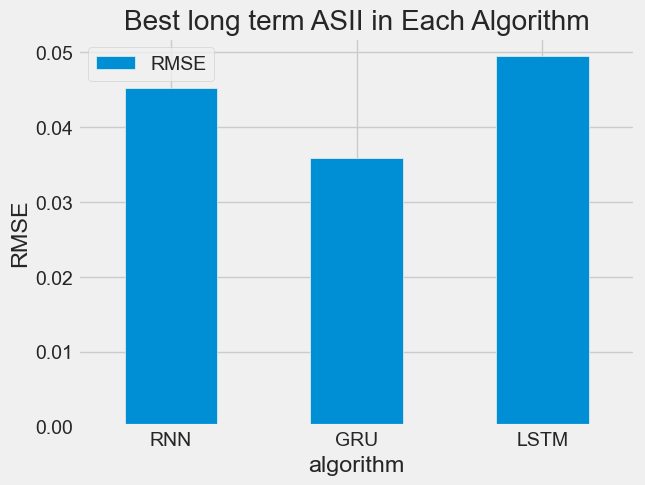

In [1206]:
data_tuning_long_ASII = pd.concat([minimum_config_RNN_ASII, minimum_config_GRU_ASII, minimum_config_LSTM_ASII]).rename(columns={"rmse_norm" : "RMSE" })
bar_ASII_tuning_long = data_tuning_long_ASII.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best long term ASII in Each Algorithm")
data_tuning_long_ASII

735 372
12/12 [==============================] - 1s 17ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

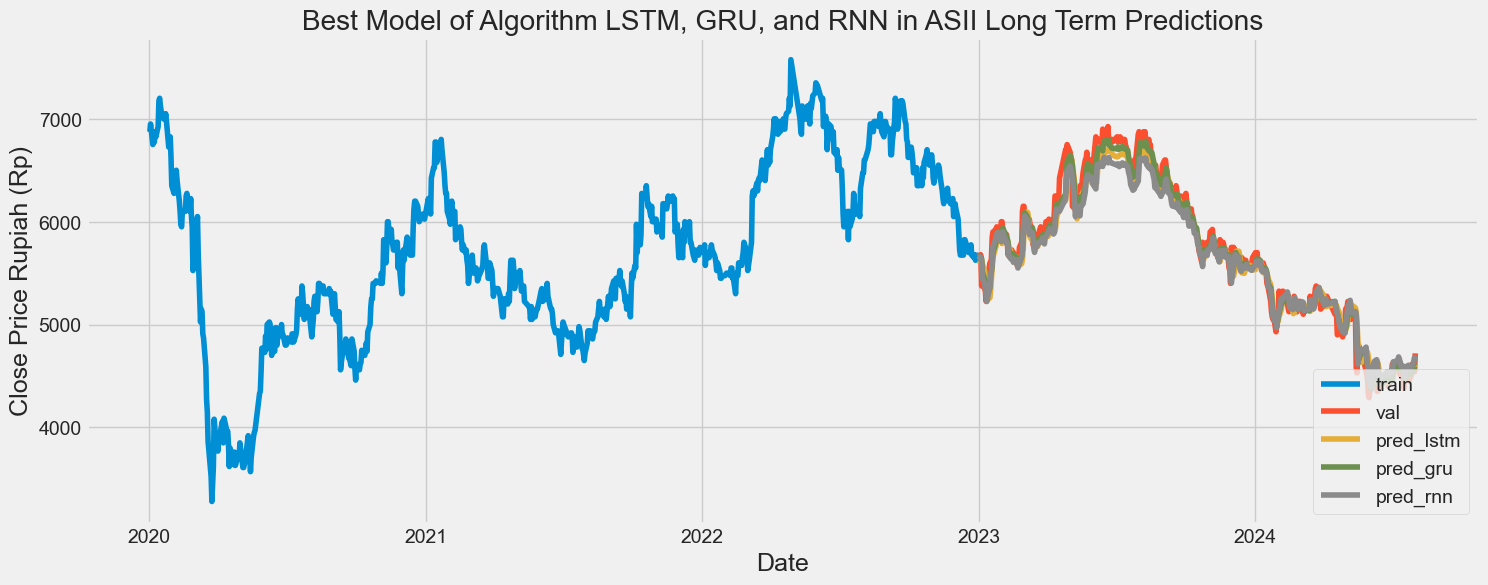

In [1274]:
rnn_best = ['rmsprop', 32, 50, 50]
gru_best =['adam', 32, 50, 50]
lstm_best = ['adam', 32, 50, 100]
show_all_algorithm(ASII, "long", "2020-01-01", "2022-12-31", "2024-07-31", 60, "ASII", lstm_best, gru_best, rnn_best)

In [1208]:
#Best Model for ASII long
minimum_ASII_long = data_tuning_long_ASII["RMSE"].min()
minimum_config_ASII_long = data_tuning_long_ASII[data_tuning_long_ASII["RMSE"] == minimum_ASII_long]
minimum_config_ASII_long

stock  term algorithm       rmse      RMSE  epoch  unit optimizer  \
19  ASII  long       GRU  90.945713  0.035876     50    50      adam   

    batch_size  
19          32

735 372
12/12 [==============================] - 2s 39ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


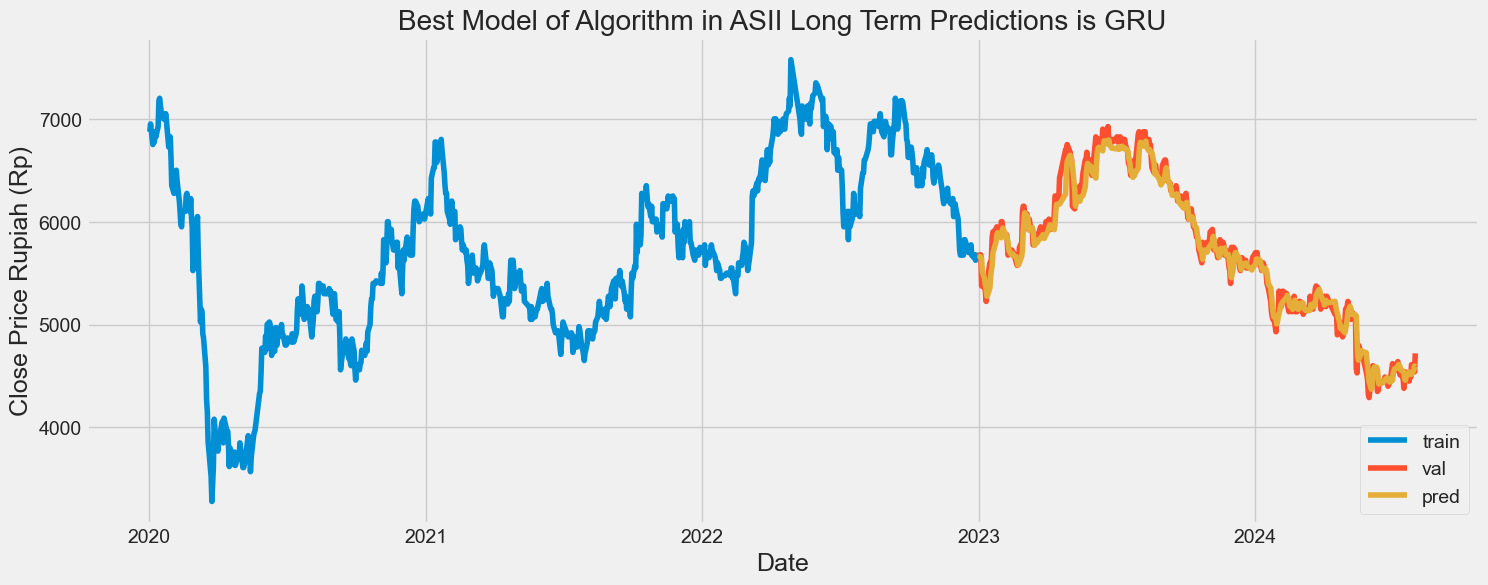

In [1209]:
show_each_algorithm(ASII, "long","2020-01-01", "2022-12-31", "2024-07-31", 60, "ASII", "gru", "adam", 32, 50, 50)

### AMRT

In [1210]:
data_AMRT_long = model_long[model_long["stock"] == "AMRT"]
data_AMRT_long.head()

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
3   AMRT  long      LSTM   85.819877   0.161924     50    50   rmsprop   
4   AMRT  long       GRU  378.519532   0.424805     50    50   rmsprop   
5   AMRT  long       RNN   61.072109   0.115230     50    50   rmsprop   
21  AMRT  long      LSTM   89.416180   0.168710     50    50      adam   
22  AMRT  long       GRU   85.725099   0.161745     50    50      adam   

    batch_size  
3           32  
4           32  
5           32  
21          32  
22          32

#### LSTM

In [1211]:
data_AMRT_LSTM_long = data_AMRT_long[data_AMRT_long["algorithm"] == "LSTM"]
minimum_LSTM_AMRT = data_AMRT_LSTM_long["rmse_norm"].min()
minimum_config_LSTM_AMRT = data_AMRT_LSTM_long[data_AMRT_LSTM_long["rmse_norm"] == minimum_LSTM_AMRT]
minimum_config_LSTM_AMRT

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
129  AMRT  long      LSTM  74.762638   0.141062     50   100      adam   

     batch_size  
129          32

#### GRU

In [1212]:
data_AMRT_GRU_long = data_AMRT_long[data_AMRT_long["algorithm"] == "GRU"]
minimum_GRU_AMRT = data_AMRT_GRU_long["rmse_norm"].min()
minimum_config_GRU_AMRT = data_AMRT_GRU_long[data_AMRT_GRU_long["rmse_norm"] == minimum_GRU_AMRT]
minimum_config_GRU_AMRT

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
130  AMRT  long       GRU  71.662189   0.135212     50   100      adam   

     batch_size  
130          32

#### RNN

In [1213]:
data_AMRT_RNN_long = data_AMRT_long[data_AMRT_long["algorithm"] == "RNN"]
minimum_RNN_AMRT = data_AMRT_RNN_long["rmse_norm"].min()
minimum_config_RNN_AMRT = data_AMRT_RNN_long[data_AMRT_RNN_long["rmse_norm"] == minimum_RNN_AMRT]
minimum_config_RNN_AMRT

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
5  AMRT  long       RNN  61.072109    0.11523     50    50   rmsprop   

   batch_size  
5          32

#### Best Model

stock  term algorithm       rmse      RMSE  epoch  unit optimizer  \
5    AMRT  long       RNN  61.072109  0.115230     50    50   rmsprop   
130  AMRT  long       GRU  71.662189  0.135212     50   100      adam   
129  AMRT  long      LSTM  74.762638  0.141062     50   100      adam   

     batch_size  
5            32  
130          32  
129          32

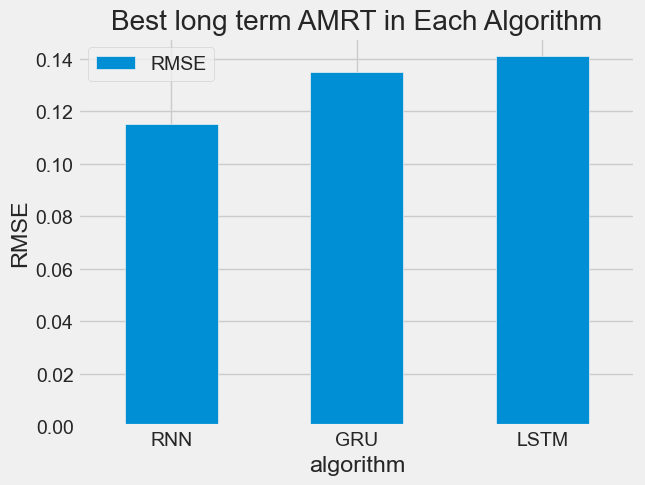

In [1214]:
data_tuning_long_AMRT = pd.concat([minimum_config_RNN_AMRT, minimum_config_GRU_AMRT, minimum_config_LSTM_AMRT]).rename(columns={"rmse_norm" : "RMSE" })
bar_AMRT_tuning_long = data_tuning_long_AMRT.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best long term AMRT in Each Algorithm")
data_tuning_long_AMRT

735 372
12/12 [==============================] - 1s 15ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

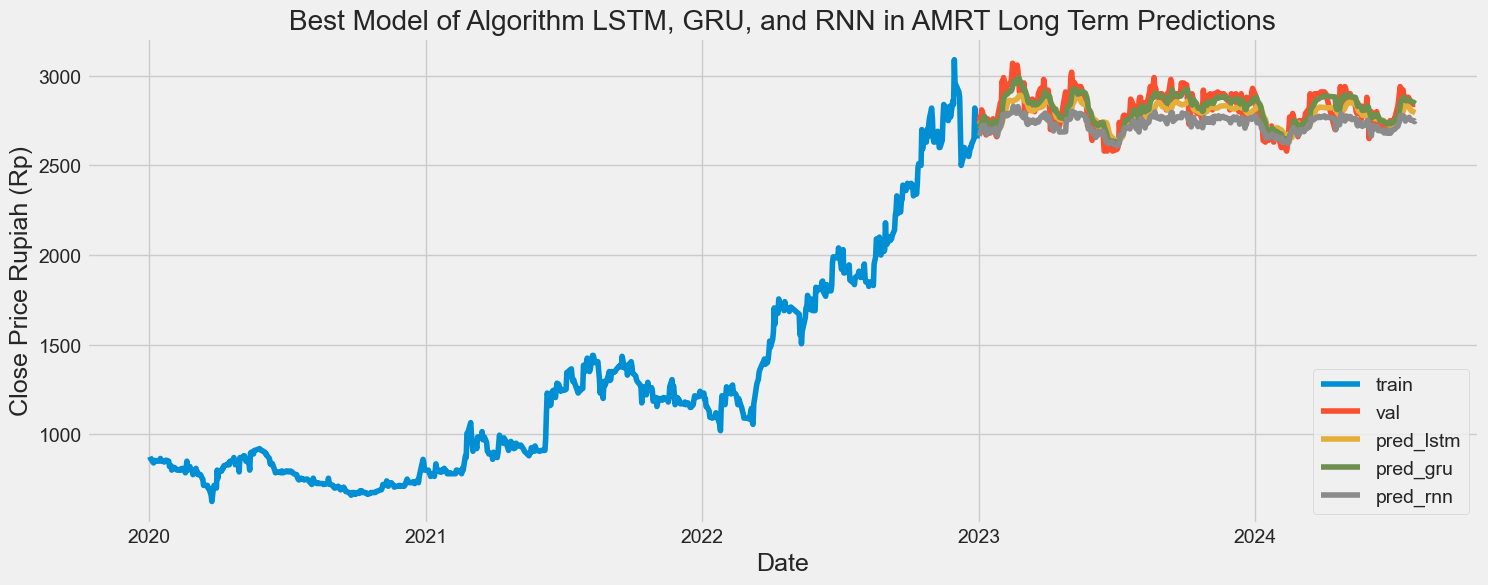

In [1275]:
rnn_best = ['rmsprop', 32, 50, 50] 
gru_best =['adam', 32, 50, 100]
lstm_best = ['adam', 32, 50, 100]
show_all_algorithm(AMRT, "long", "2020-01-01", "2022-12-31", "2024-07-31", 60, "AMRT", lstm_best, gru_best, rnn_best)

In [1216]:
#Best Model for AMRT long
minimum_AMRT_long = data_tuning_long_AMRT["RMSE"].min()
minimum_config_AMRT_long = data_tuning_long_AMRT[data_tuning_long_AMRT["RMSE"] == minimum_AMRT_long]
minimum_config_AMRT_long

stock  term algorithm       rmse     RMSE  epoch  unit optimizer  batch_size
5  AMRT  long       RNN  61.072109  0.11523     50    50   rmsprop          32

735 372
12/12 [==============================] - 1s 15ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


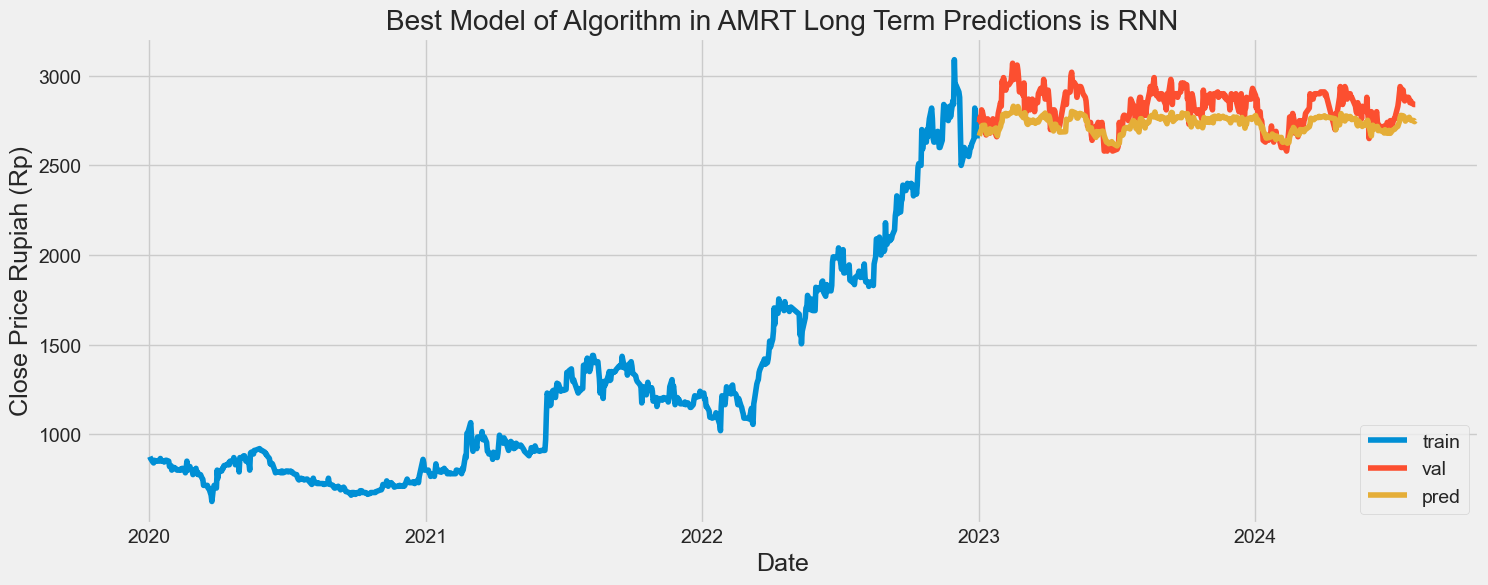

In [1217]:
show_each_algorithm(AMRT, "long","2020-01-01", "2022-12-31", "2024-07-31", 60, "AMRT", "rnn", "rmsprop", 32, 50, 50)

### ADRO

In [1218]:
data_ADRO_long = model_long[model_long["stock"] == "ADRO"]
data_ADRO_long.head()

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
6   ADRO  long      LSTM  142.066104   0.089915     50    50   rmsprop   
7   ADRO  long       GRU  186.157352   0.117821     50    50   rmsprop   
8   ADRO  long       RNN  161.447083   0.097582     50    50   rmsprop   
24  ADRO  long      LSTM  128.380001   0.081253     50    50      adam   
25  ADRO  long       GRU  128.533285   0.081350     50    50      adam   

    batch_size  
6           32  
7           32  
8           32  
24          32  
25          32

#### LSTM

In [1219]:
data_ADRO_LSTM_long = data_ADRO_long[data_ADRO_long["algorithm"] == "LSTM"]
minimum_LSTM_ADRO = data_ADRO_LSTM_long["rmse_norm"].min()
minimum_config_LSTM_ADRO = data_ADRO_LSTM_long[data_ADRO_LSTM_long["rmse_norm"] == minimum_LSTM_ADRO]
minimum_config_LSTM_ADRO

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
24  ADRO  long      LSTM  128.380001   0.081253     50    50      adam   

    batch_size  
24          32

#### GRU

In [1220]:
data_ADRO_GRU_long = data_ADRO_long[data_ADRO_long["algorithm"] == "GRU"]
minimum_GRU_ADRO = data_ADRO_GRU_long["rmse_norm"].min()
minimum_config_GRU_ADRO = data_ADRO_GRU_long[data_ADRO_GRU_long["rmse_norm"] == minimum_GRU_ADRO]
minimum_config_GRU_ADRO

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
133  ADRO  long       GRU  115.869519   0.073335     50   100      adam   

     batch_size  
133          32

#### RNN

In [1221]:
data_ADRO_RNN_long = data_ADRO_long[data_ADRO_long["algorithm"] == "RNN"]
minimum_RNN_ADRO = data_ADRO_RNN_long["rmse_norm"].min()
minimum_config_RNN_ADRO = data_ADRO_RNN_long[data_ADRO_RNN_long["rmse_norm"] == minimum_RNN_ADRO]
minimum_config_RNN_ADRO

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
62  ADRO  long       RNN  94.993419   0.057883     50    50   rmsprop   

    batch_size  
62          64

#### Best Model

stock  term algorithm        rmse      RMSE  epoch  unit optimizer  \
62   ADRO  long       RNN   94.993419  0.057883     50    50   rmsprop   
133  ADRO  long       GRU  115.869519  0.073335     50   100      adam   
24   ADRO  long      LSTM  128.380001  0.081253     50    50      adam   

     batch_size  
62           64  
133          32  
24           32

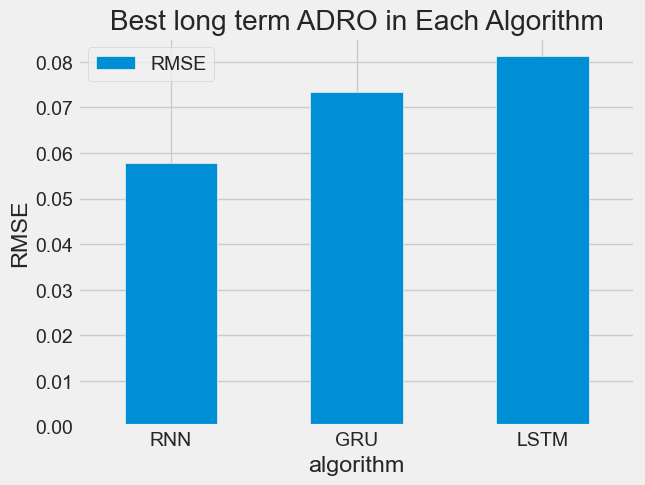

In [1222]:
data_tuning_long_ADRO = pd.concat([minimum_config_RNN_ADRO, minimum_config_GRU_ADRO, minimum_config_LSTM_ADRO]).rename(columns={"rmse_norm" : "RMSE" })
bar_ADRO_tuning_long = data_tuning_long_ADRO.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best long term ADRO in Each Algorithm")
data_tuning_long_ADRO

735 372
12/12 [==============================] - 1s 17ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

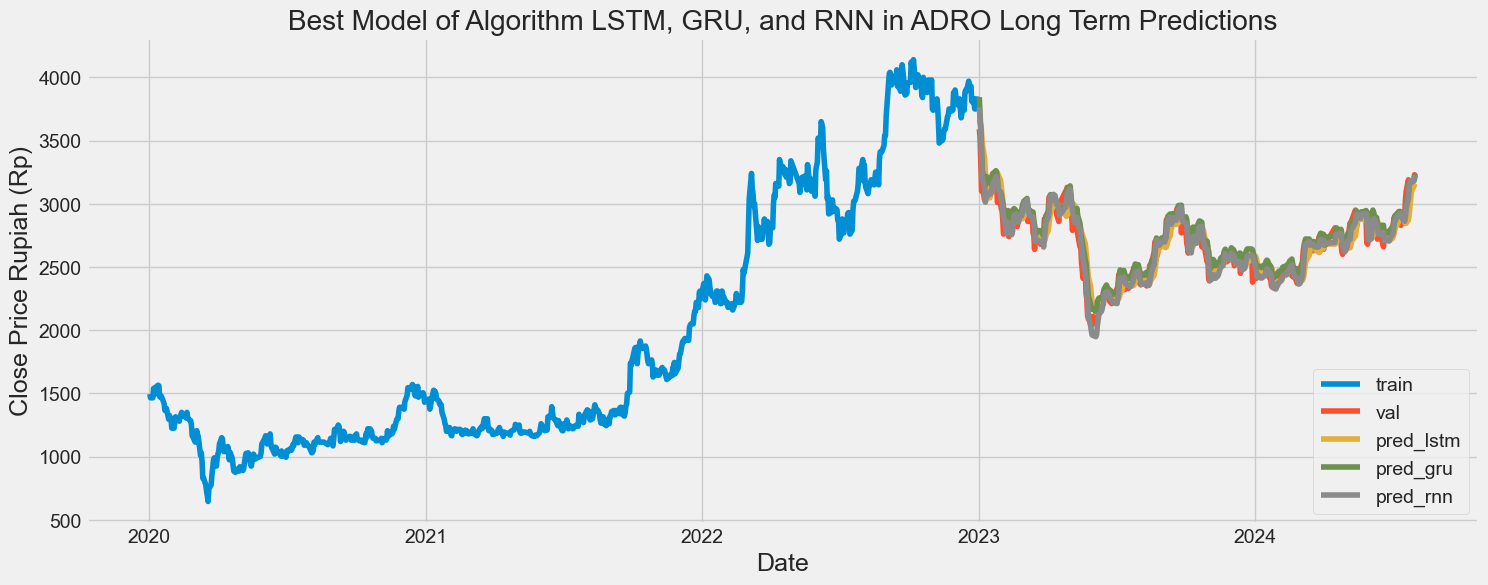

In [1276]:
rnn_best = ['rmsprop', 64, 50, 50] 
gru_best =['adam', 32, 50, 100]
lstm_best = ['adam', 32, 50, 50]
show_all_algorithm(ADRO, "long", "2020-01-01", "2022-12-31", "2024-07-31", 60, "ADRO", lstm_best, gru_best, rnn_best)

In [1223]:
#Best Model for ADRO long
minimum_ADRO_long = data_tuning_long_ADRO["RMSE"].min()
minimum_config_ADRO_long = data_tuning_long_ADRO[data_tuning_long_ADRO["RMSE"] == minimum_ADRO_long]
minimum_config_ADRO_long

stock  term algorithm       rmse      RMSE  epoch  unit optimizer  \
62  ADRO  long       RNN  94.993419  0.057883     50    50   rmsprop   

    batch_size  
62          64

735 372
12/12 [==============================] - 1s 10ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


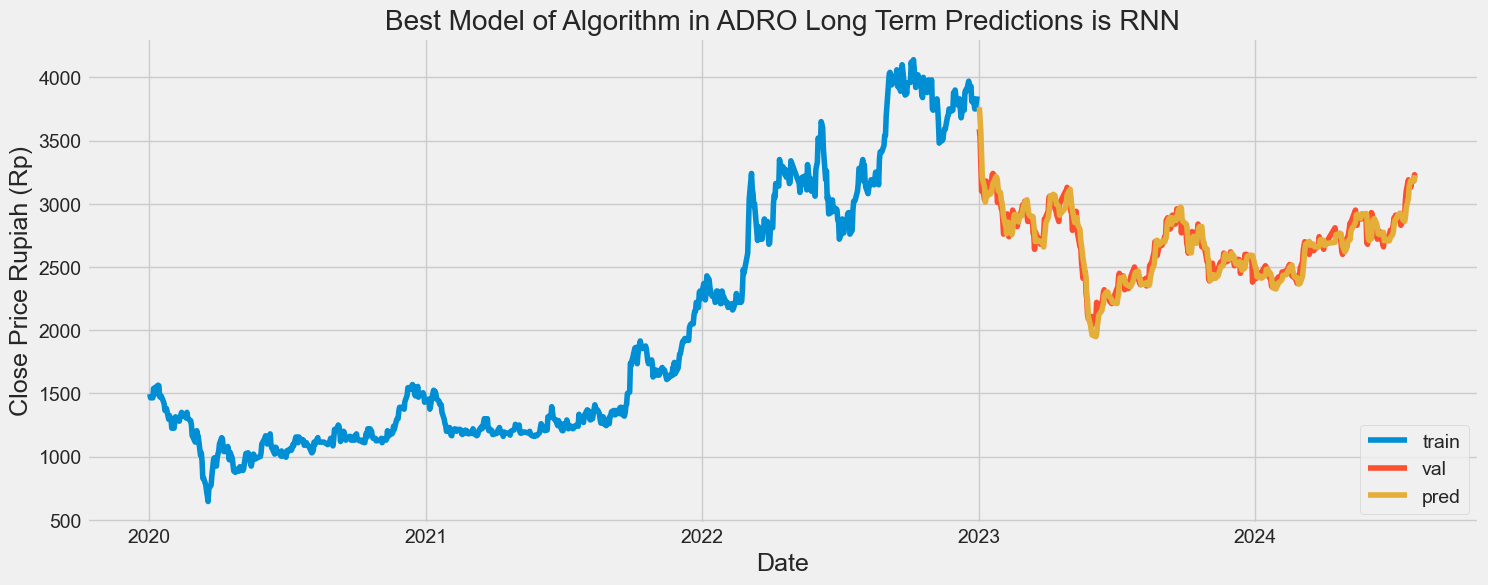

In [1224]:
show_each_algorithm(ADRO, "long","2020-01-01", "2022-12-31", "2024-07-31", 60, "ADRO", "rnn", "rmsprop", 64, 50, 50)

### MAPI

In [1225]:
data_MAPI_long = model_long[model_long["stock"] == "MAPI"]
data_MAPI_long.head()

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
9   MAPI  long      LSTM   91.273075   0.113383     50    50   rmsprop   
10  MAPI  long       GRU  128.009271   0.147683     50    50   rmsprop   
11  MAPI  long       RNN   94.488944   0.105479     50    50   rmsprop   
27  MAPI  long      LSTM   90.775873   0.112765     50    50      adam   
28  MAPI  long       GRU  100.168446   0.118075     50    50      adam   

    batch_size  
9           32  
10          32  
11          32  
27          32  
28          32

#### LSTM

In [1226]:
data_MAPI_LSTM_long = data_MAPI_long[data_MAPI_long["algorithm"] == "LSTM"]
minimum_LSTM_MAPI = data_MAPI_LSTM_long["rmse_norm"].min()
minimum_config_LSTM_MAPI = data_MAPI_LSTM_long[data_MAPI_LSTM_long["rmse_norm"] == minimum_LSTM_MAPI]
minimum_config_LSTM_MAPI

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
135  MAPI  long      LSTM  86.438454   0.107377     50   100      adam   

     batch_size  
135          32

#### GRU

In [1227]:
data_MAPI_GRU_long = data_MAPI_long[data_MAPI_long["algorithm"] == "GRU"]
minimum_GRU_MAPI = data_MAPI_GRU_long["rmse_norm"].min()
minimum_config_GRU_MAPI = data_MAPI_GRU_long[data_MAPI_GRU_long["rmse_norm"] == minimum_GRU_MAPI]
minimum_config_GRU_MAPI

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
118  MAPI  long       GRU  60.411989   0.075046     50   100   rmsprop   

     batch_size  
118          32

#### RNN

In [1228]:
data_MAPI_RNN_long = data_MAPI_long[data_MAPI_long["algorithm"] == "RNN"]
minimum_RNN_MAPI = data_MAPI_RNN_long["rmse_norm"].min()
minimum_config_RNN_MAPI = data_MAPI_RNN_long[data_MAPI_RNN_long["rmse_norm"] == minimum_RNN_MAPI]
minimum_config_RNN_MAPI

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
65  MAPI  long       RNN  64.644759   0.080304     50    50   rmsprop   

    batch_size  
65          64

#### Best Model

stock  term algorithm       rmse      RMSE  epoch  unit optimizer  \
65   MAPI  long       RNN  64.644759  0.080304     50    50   rmsprop   
118  MAPI  long       GRU  60.411989  0.075046     50   100   rmsprop   
135  MAPI  long      LSTM  86.438454  0.107377     50   100      adam   

     batch_size  
65           64  
118          32  
135          32

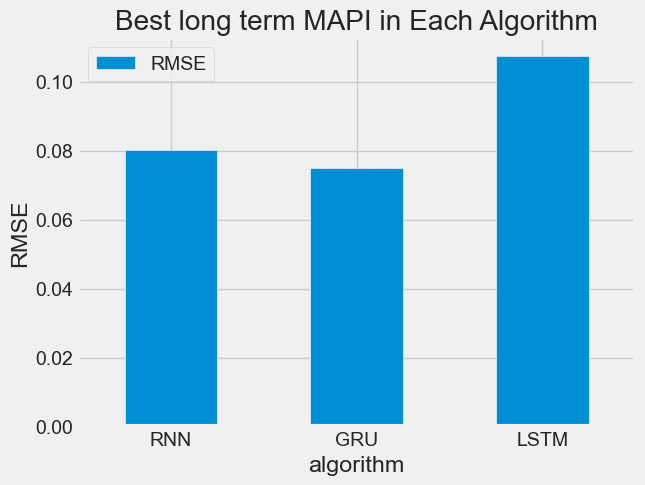

In [1229]:
data_tuning_long_MAPI = pd.concat([minimum_config_RNN_MAPI, minimum_config_GRU_MAPI, minimum_config_LSTM_MAPI]).rename(columns={"rmse_norm" : "RMSE" })
bar_MAPI_tuning_long = data_tuning_long_MAPI.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best long term MAPI in Each Algorithm")
data_tuning_long_MAPI

735 372
12/12 [==============================] - 1s 16ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

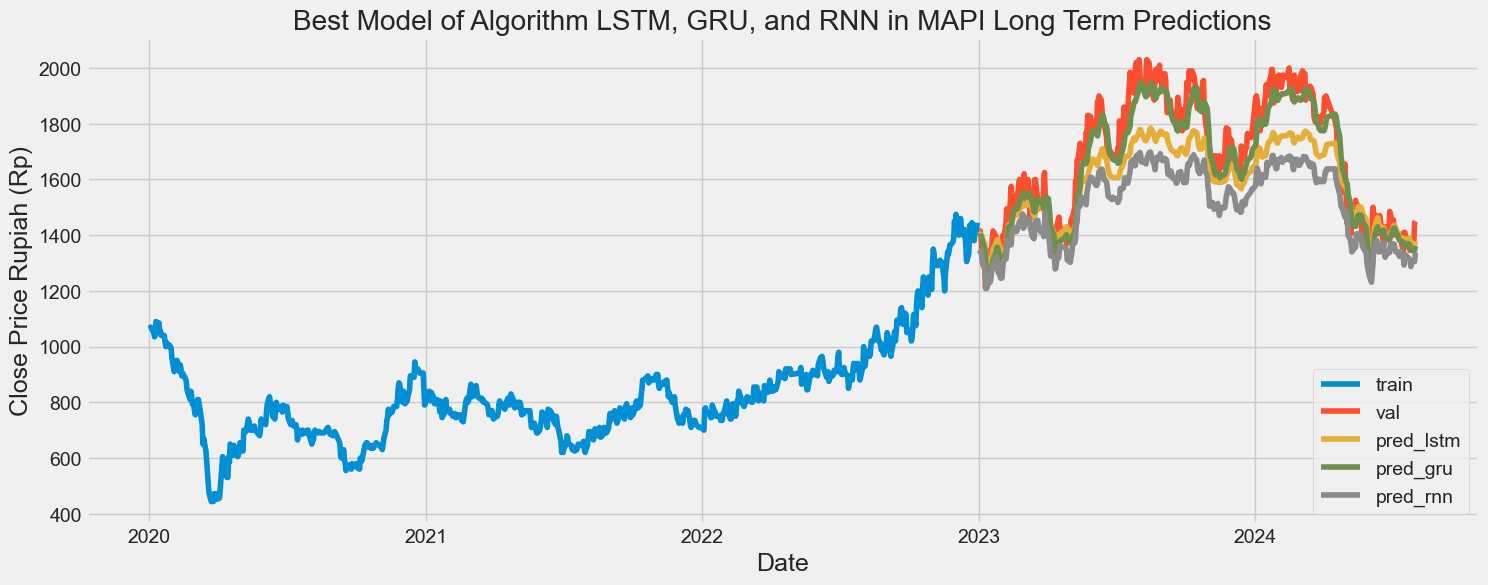

In [1277]:
rnn_best = ['rmsprop', 64, 50, 50] 
gru_best =['rmsprop', 32, 50, 100]
lstm_best = ['adam', 32, 50, 100]
show_all_algorithm(MAPI, "long", "2020-01-01", "2022-12-31", "2024-07-31", 60, "MAPI", lstm_best, gru_best, rnn_best)

In [1230]:
#Best Model for MAPI long
minimum_MAPI_long = data_tuning_long_MAPI["RMSE"].min()
minimum_config_MAPI_long = data_tuning_long_MAPI[data_tuning_long_MAPI["RMSE"] == minimum_MAPI_long]
minimum_config_MAPI_long

stock  term algorithm       rmse      RMSE  epoch  unit optimizer  \
118  MAPI  long       GRU  60.411989  0.075046     50   100   rmsprop   

     batch_size  
118          32

735 372
12/12 [==============================] - 3s 60ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


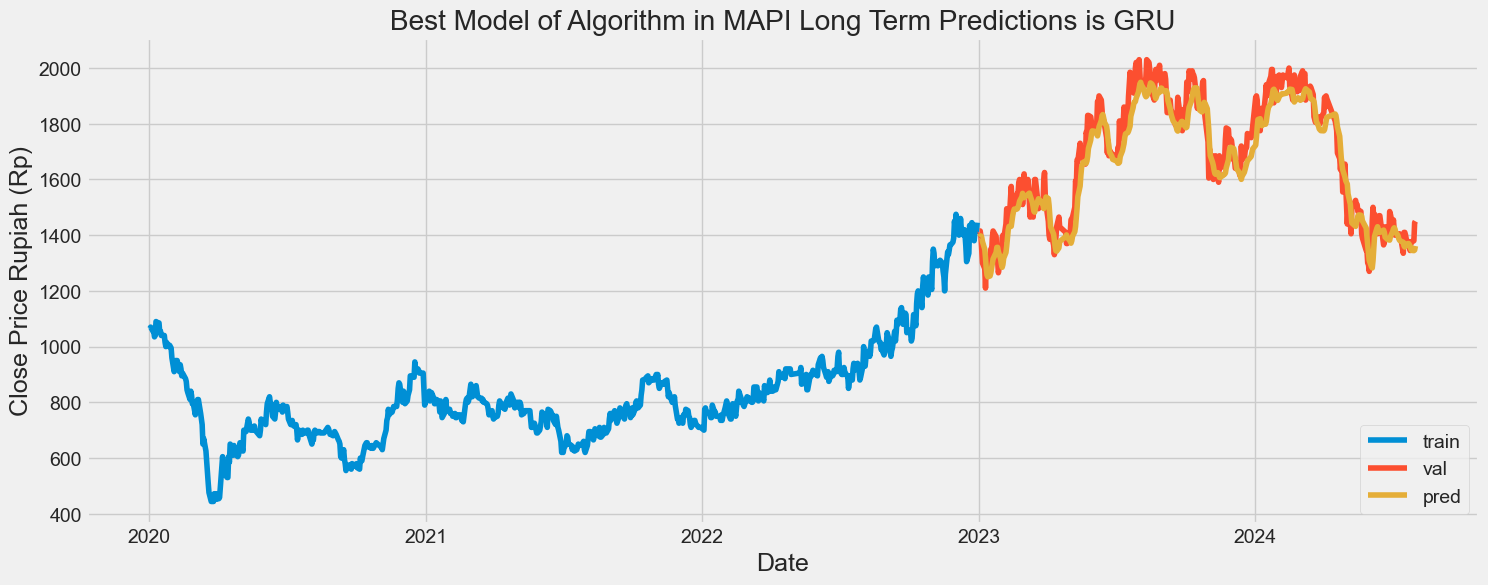

In [1231]:
show_each_algorithm(MAPI, "long","2020-01-01", "2022-12-31", "2024-07-31", 60, "MAPI", "gru", "rmsprop", 32, 50, 100)

### KLBF

In [1232]:
data_KLBF_long = model_long[model_long["stock"] == "KLBF"]
data_KLBF_long.head()

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
12  KLBF  long      LSTM  97.350467   0.100287     50    50   rmsprop   
13  KLBF  long       GRU  61.596232   0.067451     50    50   rmsprop   
14  KLBF  long       RNN  98.210320   0.108520     50    50   rmsprop   
30  KLBF  long      LSTM  72.659141   0.080286     50    50      adam   
31  KLBF  long       GRU  51.882926   0.056309     50    50      adam   

    batch_size  
12          32  
13          32  
14          32  
30          32  
31          32

#### LSTM

In [1233]:
data_KLBF_LSTM_long = data_KLBF_long[data_KLBF_long["algorithm"] == "LSTM"]
minimum_LSTM_KLBF = data_KLBF_LSTM_long["rmse_norm"].min()
minimum_config_LSTM_KLBF = data_KLBF_LSTM_long[data_KLBF_LSTM_long["rmse_norm"] == minimum_LSTM_KLBF]
minimum_config_LSTM_KLBF

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
30  KLBF  long      LSTM  72.659141   0.080286     50    50      adam   

    batch_size  
30          32

#### GRU

In [1234]:
data_KLBF_GRU_long = data_KLBF_long[data_KLBF_long["algorithm"] == "GRU"]
minimum_GRU_KLBF = data_KLBF_GRU_long["rmse_norm"].min()
minimum_config_GRU_KLBF = data_KLBF_GRU_long[data_KLBF_GRU_long["rmse_norm"] == minimum_GRU_KLBF]
minimum_config_GRU_KLBF

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
31  KLBF  long       GRU  51.882926   0.056309     50    50      adam   

    batch_size  
31          32

#### RNN

In [1235]:
data_KLBF_RNN_long = data_KLBF_long[data_KLBF_long["algorithm"] == "RNN"]
minimum_RNN_KLBF = data_KLBF_RNN_long["rmse_norm"].min()
minimum_config_RNN_KLBF = data_KLBF_RNN_long[data_KLBF_RNN_long["rmse_norm"] == minimum_RNN_KLBF]
minimum_config_RNN_KLBF

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
32  KLBF  long       RNN  72.819584   0.079951     50    50      adam   

    batch_size  
32          32

#### Best Model

stock  term algorithm       rmse      RMSE  epoch  unit optimizer  \
32  KLBF  long       RNN  72.819584  0.079951     50    50      adam   
31  KLBF  long       GRU  51.882926  0.056309     50    50      adam   
30  KLBF  long      LSTM  72.659141  0.080286     50    50      adam   

    batch_size  
32          32  
31          32  
30          32

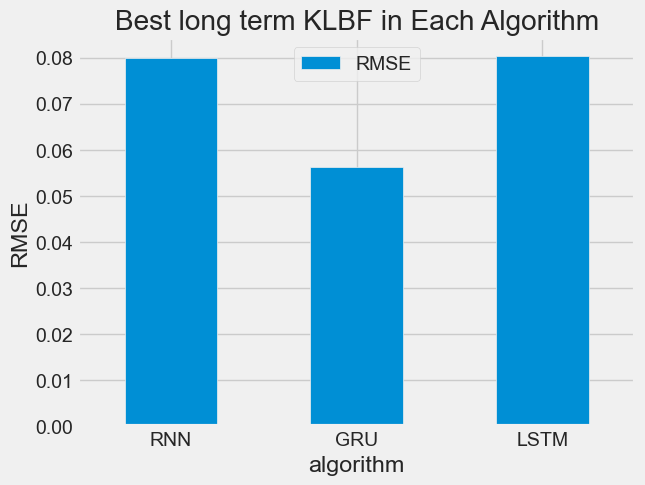

In [1236]:
data_tuning_long_KLBF = pd.concat([minimum_config_RNN_KLBF, minimum_config_GRU_KLBF, minimum_config_LSTM_KLBF]).rename(columns={"rmse_norm" : "RMSE" })
bar_KLBF_tuning_long = data_tuning_long_KLBF.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best long term KLBF in Each Algorithm")
data_tuning_long_KLBF

735 372
12/12 [==============================] - 1s 16ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

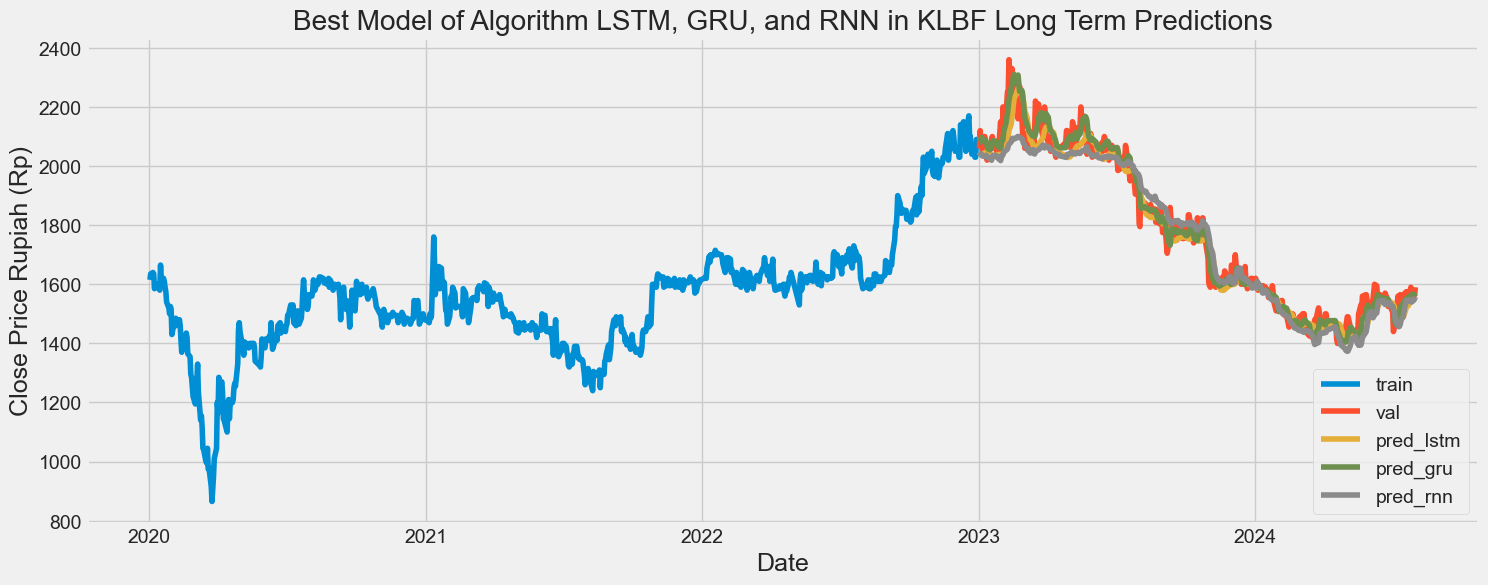

In [1278]:
rnn_best = ['adam', 32, 50, 50] 
gru_best =['adam', 32, 50, 50]
lstm_best = ['adam', 32, 50, 50]
show_all_algorithm(KLBF, "long", "2020-01-01", "2022-12-31", "2024-07-31", 60, "KLBF", lstm_best, gru_best, rnn_best)

In [1237]:
#Best Model for KLBF long
minimum_KLBF_long = data_tuning_long_KLBF["RMSE"].min()
minimum_config_KLBF_long = data_tuning_long_KLBF[data_tuning_long_KLBF["RMSE"] == minimum_KLBF_long]
minimum_config_KLBF_long

stock  term algorithm       rmse      RMSE  epoch  unit optimizer  \
31  KLBF  long       GRU  51.882926  0.056309     50    50      adam   

    batch_size  
31          32

735 372
12/12 [==============================] - 2s 39ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


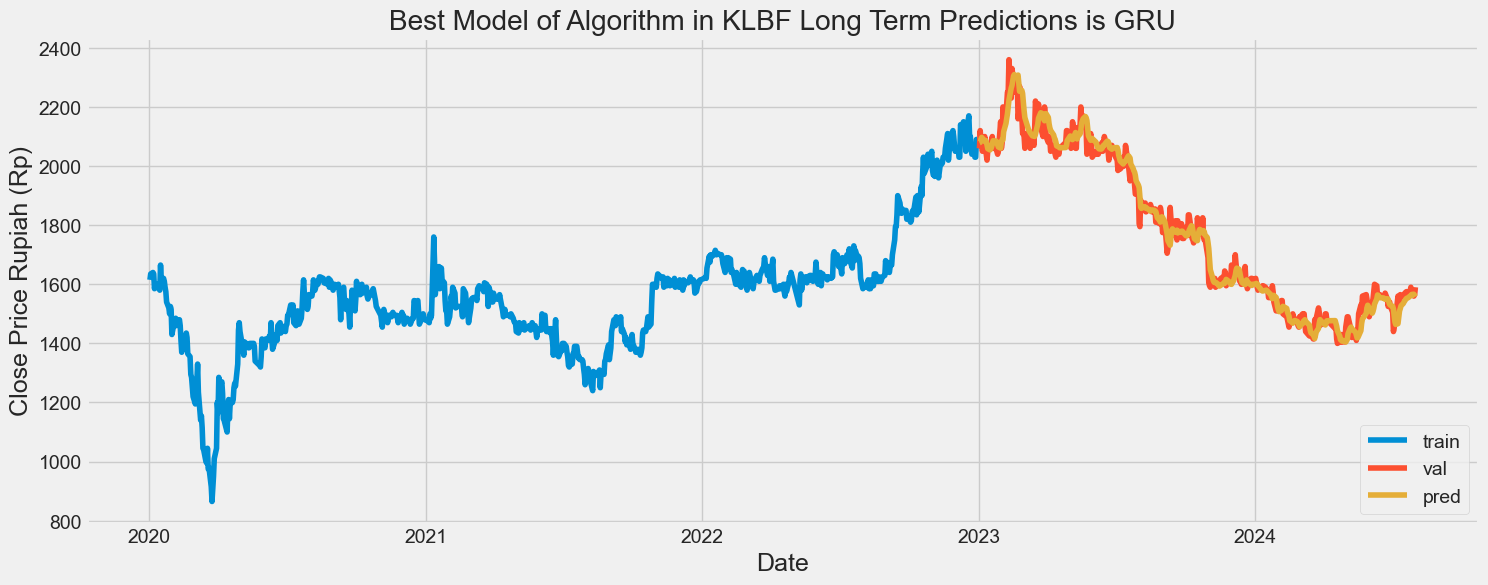

In [1238]:
show_each_algorithm(KLBF, "long","2020-01-01", "2022-12-31", "2024-07-31", 60, "KLBF", "gru", "adam", 32, 50, 50)

### TLKM

In [1239]:
data_TLKM_long = model_long[model_long["stock"] == "TLKM"]
data_TLKM_long.head()

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
15  TLKM  long      LSTM  155.094316   0.090299     50    50   rmsprop   
16  TLKM  long       GRU  155.046169   0.090727     50    50   rmsprop   
17  TLKM  long       RNN   72.961108   0.044761     50    50   rmsprop   
33  TLKM  long      LSTM  117.810239   0.071460     50    50      adam   
34  TLKM  long       GRU   90.394444   0.054572     50    50      adam   

    batch_size  
15          32  
16          32  
17          32  
33          32  
34          32

#### LSTM

In [1240]:
data_TLKM_LSTM_long = data_TLKM_long[data_TLKM_long["algorithm"] == "LSTM"]
minimum_LSTM_TLKM = data_TLKM_LSTM_long["rmse_norm"].min()
minimum_config_LSTM_TLKM = data_TLKM_LSTM_long[data_TLKM_LSTM_long["rmse_norm"] == minimum_LSTM_TLKM]
minimum_config_LSTM_TLKM

stock  term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
33  TLKM  long      LSTM  117.810239    0.07146     50    50      adam   

    batch_size  
33          32

#### GRU

In [1241]:
data_TLKM_GRU_long = data_TLKM_long[data_TLKM_long["algorithm"] == "GRU"]
minimum_GRU_TLKM = data_TLKM_GRU_long["rmse_norm"].min()
minimum_config_GRU_TLKM = data_TLKM_GRU_long[data_TLKM_GRU_long["rmse_norm"] == minimum_GRU_TLKM]
minimum_config_GRU_TLKM

stock  term algorithm      rmse  rmse_norm  epoch  unit optimizer  \
124  TLKM  long       GRU  63.62064   0.039031     50   100   rmsprop   

     batch_size  
124          32

#### RNN

In [1242]:
data_TLKM_RNN_long = data_TLKM_long[data_TLKM_long["algorithm"] == "RNN"]
minimum_RNN_TLKM = data_TLKM_RNN_long["rmse_norm"].min()
minimum_config_RNN_TLKM = data_TLKM_RNN_long[data_TLKM_RNN_long["rmse_norm"] == minimum_RNN_TLKM]
minimum_config_RNN_TLKM

stock  term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
71  TLKM  long       RNN  63.547393   0.038061     50    50   rmsprop   

    batch_size  
71          64

#### Best Model

stock  term algorithm        rmse      RMSE  epoch  unit optimizer  \
71   TLKM  long       RNN   63.547393  0.038061     50    50   rmsprop   
124  TLKM  long       GRU   63.620640  0.039031     50   100   rmsprop   
33   TLKM  long      LSTM  117.810239  0.071460     50    50      adam   

     batch_size  
71           64  
124          32  
33           32

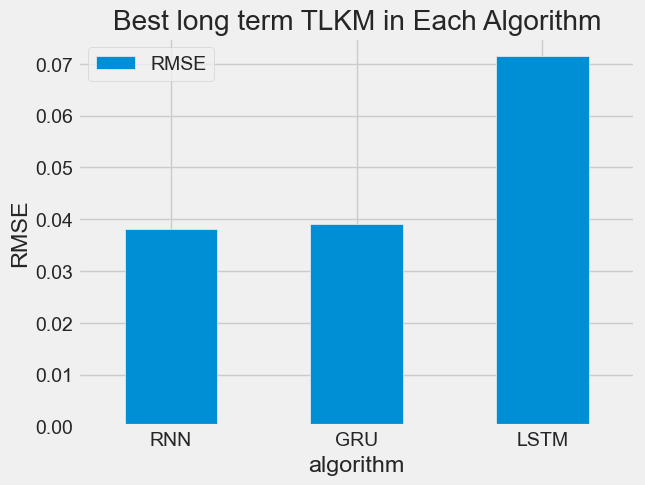

In [1243]:
data_tuning_long_TLKM = pd.concat([minimum_config_RNN_TLKM, minimum_config_GRU_TLKM, minimum_config_LSTM_TLKM]).rename(columns={"rmse_norm" : "RMSE" })
bar_TLKM_tuning_long = data_tuning_long_TLKM.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best long term TLKM in Each Algorithm")
data_tuning_long_TLKM

735 372
12/12 [==============================] - 1s 17ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

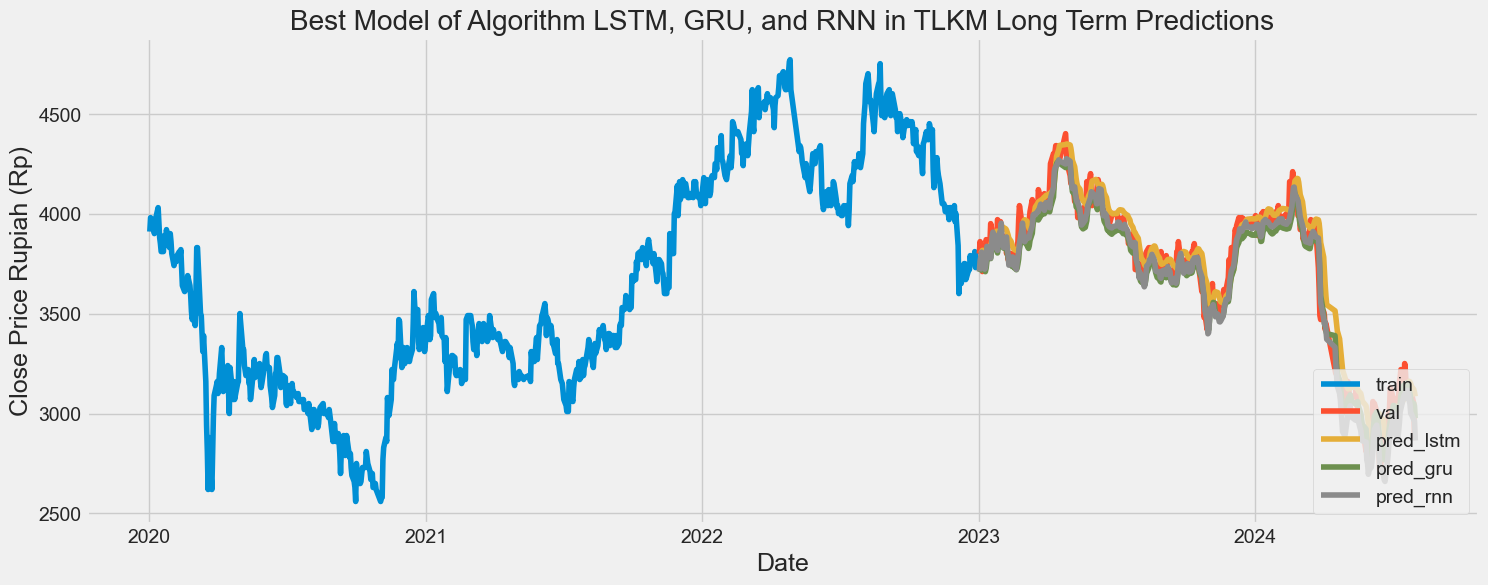

In [1298]:
rnn_best = ['rmsprop', 64, 50, 50] 
gru_best =['rmsprop', 32, 50, 100]
lstm_best = ['adam', 32, 50, 50]
show_all_algorithm(TLKM, "long", "2020-01-01", "2022-12-31", "2024-07-31", 60, "TLKM", lstm_best, gru_best, rnn_best)

In [1244]:
#Best Model for TLKM long
minimum_TLKM_long = data_tuning_long_TLKM["RMSE"].min()
minimum_config_TLKM_long = data_tuning_long_TLKM[data_tuning_long_TLKM["RMSE"] == minimum_TLKM_long]
minimum_config_TLKM_long

stock  term algorithm       rmse      RMSE  epoch  unit optimizer  \
71  TLKM  long       RNN  63.547393  0.038061     50    50   rmsprop   

    batch_size  
71          64

735 372
12/12 [==============================] - 1s 13ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


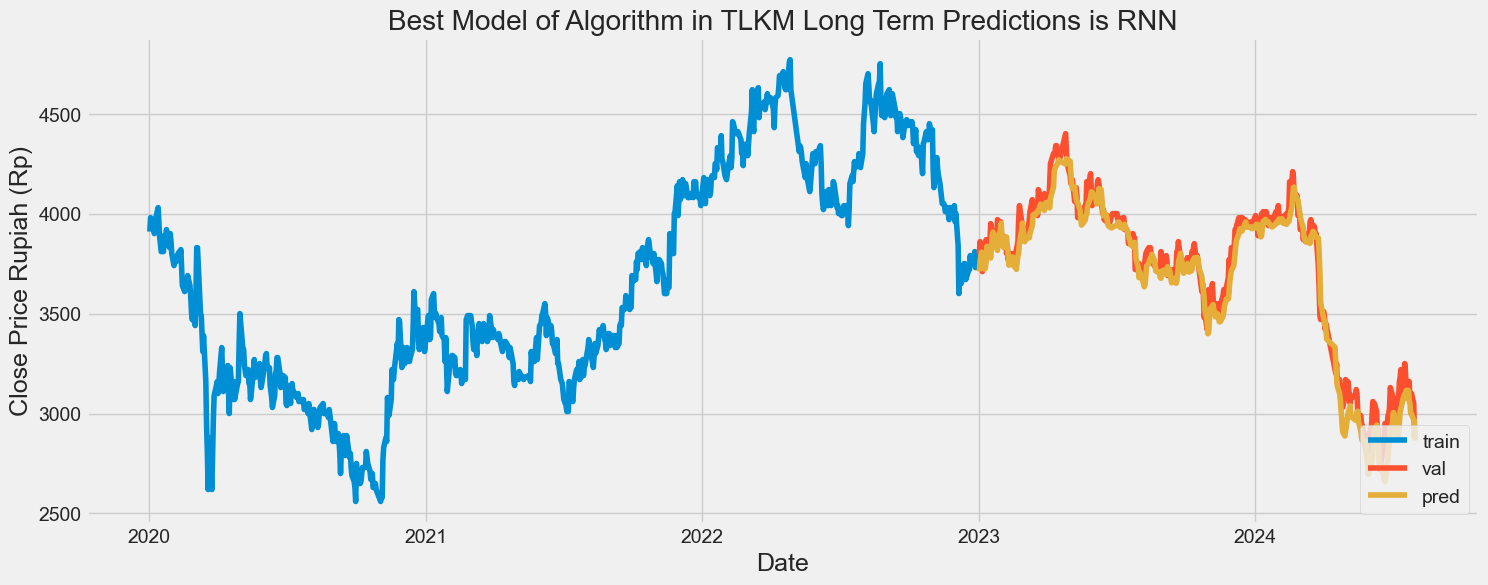

In [1245]:
show_each_algorithm(TLKM, "long","2020-01-01", "2022-12-31", "2024-07-31", 60, "TLKM", "rnn", "rmsprop", 64, 50, 50)

### Best Model for Each Stock in Long Term

stock  term algorithm       rmse      RMSE  epoch  unit optimizer  \
19   ASII  long       GRU  90.945713  0.035876     50    50      adam   
5    AMRT  long       RNN  61.072109  0.115230     50    50   rmsprop   
62   ADRO  long       RNN  94.993419  0.057883     50    50   rmsprop   
118  MAPI  long       GRU  60.411989  0.075046     50   100   rmsprop   
31   KLBF  long       GRU  51.882926  0.056309     50    50      adam   
71   TLKM  long       RNN  63.547393  0.038061     50    50   rmsprop   

     batch_size  
19           32  
5            32  
62           64  
118          32  
31           32  
71           64

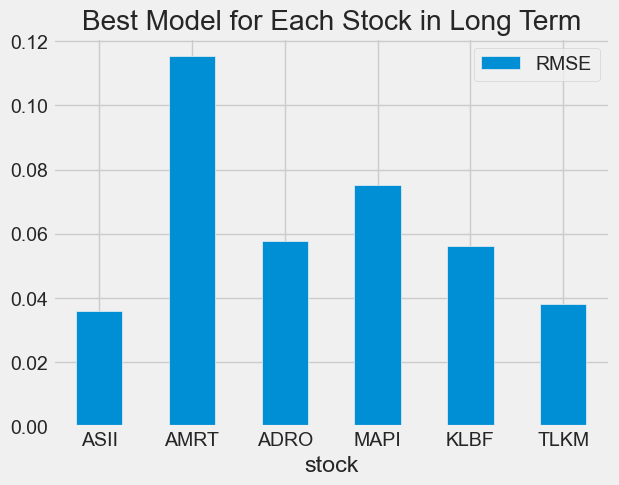

In [1288]:
best_data_long = pd.concat([minimum_config_ASII_long,
                            minimum_config_AMRT_long,
                            minimum_config_ADRO_long,
                            minimum_config_MAPI_long,
                            minimum_config_KLBF_long,
                            minimum_config_TLKM_long]
                            )
bar_tuning_long = best_data_long.plot.bar(x='stock', y=['RMSE'], rot=0, title="Best Model for Each Stock in Long Term")
best_data_long

## Medium Term
Data used is:
- Train : 2023 (1 year)
- Test : January - July 2024 (7 month)


In [1247]:
model_medium = pd.read_csv("../result_paper_tuning/result_medium_tuning.csv")
model_medium.head()

stock    term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
0  ASII  medium      LSTM  260.137083   0.194859     50    50   rmsprop   
1  ASII  medium       GRU  174.401087   0.121864     50    50   rmsprop   
2  ASII  medium       RNN  337.119504   0.180535     50    50   rmsprop   
3  AMRT  medium      LSTM   72.171872   0.176029     50    50   rmsprop   
4  AMRT  medium       GRU   67.187506   0.153464     50    50   rmsprop   

   batch_size  
0          32  
1          32  
2          32  
3          32  
4          32

### ASII

In [1248]:
data_ASII_medium = model_medium[model_medium["stock"] == "ASII"]
data_ASII_medium.head()

stock    term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
0   ASII  medium      LSTM  260.137083   0.194859     50    50   rmsprop   
1   ASII  medium       GRU  174.401087   0.121864     50    50   rmsprop   
2   ASII  medium       RNN  337.119504   0.180535     50    50   rmsprop   
18  ASII  medium      LSTM  296.981091   0.220070     50    50      adam   
19  ASII  medium       GRU  138.197089   0.101281     50    50      adam   

    batch_size  
0           32  
1           32  
2           32  
18          32  
19          32

#### LSTM

In [1249]:
data_ASII_LSTM_medium = data_ASII_medium[data_ASII_medium["algorithm"] == "LSTM"]
minimum_LSTM_ASII = data_ASII_LSTM_medium["rmse_norm"].min()
minimum_config_LSTM_ASII = data_ASII_LSTM_medium[data_ASII_LSTM_medium["rmse_norm"] == minimum_LSTM_ASII]
minimum_config_LSTM_ASII

stock    term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
216  ASII  medium      LSTM  170.749659   0.127902    100    50   rmsprop   

     batch_size  
216          32

#### GRU

In [1250]:
data_ASII_GRU_medium = data_ASII_medium[data_ASII_medium["algorithm"] == "GRU"]
minimum_GRU_ASII = data_ASII_GRU_medium["rmse_norm"].min()
minimum_config_GRU_ASII = data_ASII_GRU_medium[data_ASII_GRU_medium["rmse_norm"] == minimum_GRU_ASII]
minimum_config_GRU_ASII

stock    term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
235  ASII  medium       GRU  104.863653   0.077229    100    50      adam   

     batch_size  
235          32

#### RNN

In [1251]:
data_ASII_RNN_medium = data_ASII_medium[data_ASII_medium["algorithm"] == "RNN"]
minimum_RNN_ASII = data_ASII_RNN_medium["rmse_norm"].min()
minimum_config_RNN_ASII = data_ASII_RNN_medium[data_ASII_RNN_medium["rmse_norm"] == minimum_RNN_ASII]
minimum_config_RNN_ASII

stock    term algorithm      rmse  rmse_norm  epoch  unit optimizer  \
218  ASII  medium       RNN  126.0291   0.091287    100    50   rmsprop   

     batch_size  
218          32

#### Best Model

stock    term algorithm        rmse      RMSE  epoch  unit optimizer  \
218  ASII  medium       RNN  126.029100  0.091287    100    50   rmsprop   
235  ASII  medium       GRU  104.863653  0.077229    100    50      adam   
216  ASII  medium      LSTM  170.749659  0.127902    100    50   rmsprop   

     batch_size  
218          32  
235          32  
216          32

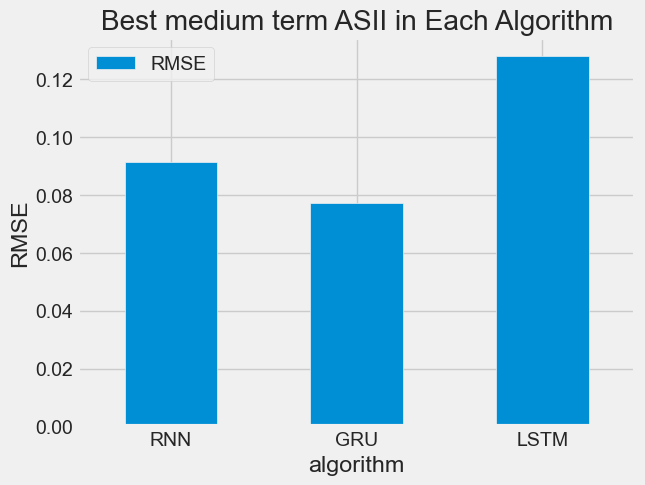

In [1252]:
data_tuning_medium_ASII = pd.concat([minimum_config_RNN_ASII, minimum_config_GRU_ASII, minimum_config_LSTM_ASII]).rename(columns={"rmse_norm" : "RMSE" })
bar_ASII_tuning_medium = data_tuning_medium_ASII.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best medium term ASII in Each Algorithm")
data_tuning_medium_ASII

239 133
5/5 [==============================] - 1s 6ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

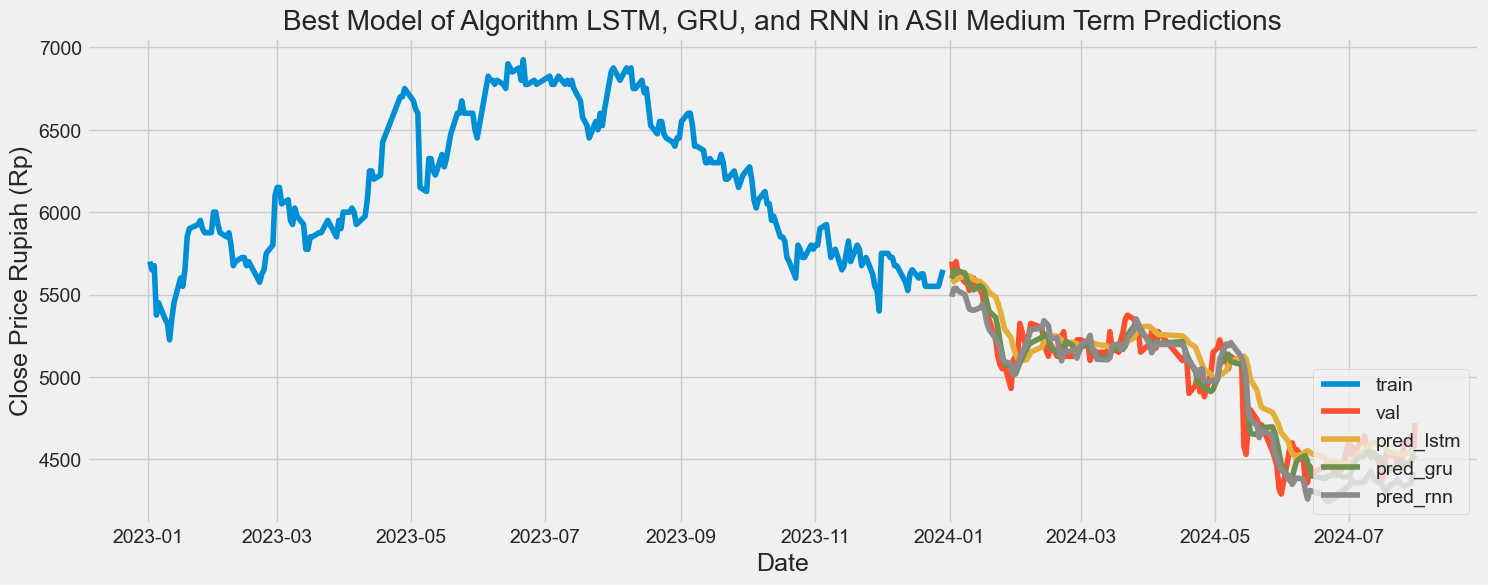

In [1280]:
rnn_best = ['rmsprop', 32, 100, 50] 
gru_best =['adam', 32, 100, 50]
lstm_best = ['rmsprop', 32, 100, 50]
show_all_algorithm(ASII, "med", "2023-01-01", "2023-12-31", "2024-07-31", 20, "ASII", lstm_best, gru_best, rnn_best)

In [1253]:
#Best Model for ASII medium
minimum_ASII_medium = data_tuning_medium_ASII["RMSE"].min()
minimum_config_ASII_medium = data_tuning_medium_ASII[data_tuning_medium_ASII["RMSE"] == minimum_ASII_medium]
minimum_config_ASII_medium

stock    term algorithm        rmse      RMSE  epoch  unit optimizer  \
235  ASII  medium       GRU  104.863653  0.077229    100    50      adam   

     batch_size  
235          32

239 133
5/5 [==============================] - 2s 17ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


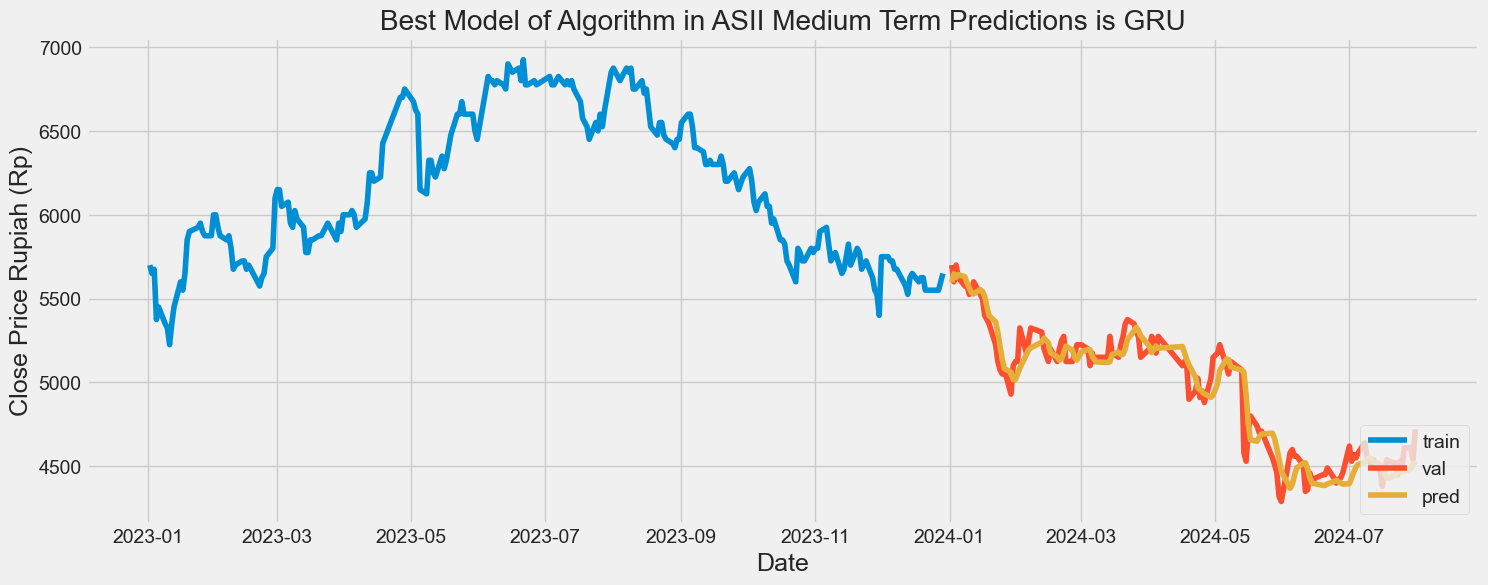

In [1256]:
show_each_algorithm(ASII, "med","2023-01-01", "2023-12-31", "2024-07-31", 20, "ASII", "gru", "adam", 32, 100, 50)

### AMRT

In [1066]:
data_AMRT_medium = model_medium[model_medium["stock"] == "AMRT"]
data_AMRT_medium.head()

stock    term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
3   AMRT  medium      LSTM   72.171872   0.176029     50    50   rmsprop   
4   AMRT  medium       GRU   67.187506   0.153464     50    50   rmsprop   
5   AMRT  medium       RNN  111.626888   0.236494     50    50   rmsprop   
21  AMRT  medium      LSTM   82.058773   0.189668     50    50      adam   
22  AMRT  medium       GRU   67.769365   0.154217     50    50      adam   

    batch_size  
3           32  
4           32  
5           32  
21          32  
22          32

#### LSTM

In [1067]:
data_AMRT_LSTM_medium = data_AMRT_medium[data_AMRT_medium["algorithm"] == "LSTM"]
minimum_LSTM_AMRT = data_AMRT_LSTM_medium["rmse_norm"].min()
minimum_config_LSTM_AMRT = data_AMRT_LSTM_medium[data_AMRT_LSTM_medium["rmse_norm"] == minimum_LSTM_AMRT]
minimum_config_LSTM_AMRT

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
111  AMRT  medium      LSTM  60.881792   0.148492     50   100   rmsprop   

     batch_size  
111          32

#### GRU

In [1068]:
data_AMRT_GRU_medium = data_AMRT_medium[data_AMRT_medium["algorithm"] == "GRU"]
minimum_GRU_AMRT = data_AMRT_GRU_medium["rmse_norm"].min()
minimum_config_GRU_AMRT = data_AMRT_GRU_medium[data_AMRT_GRU_medium["rmse_norm"] == minimum_GRU_AMRT]
minimum_config_GRU_AMRT

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
238  AMRT  medium       GRU  51.964243   0.114878    100    50      adam   

     batch_size  
238          32

#### RNN

In [1069]:
data_AMRT_RNN_medium = data_AMRT_medium[data_AMRT_medium["algorithm"] == "RNN"]
minimum_RNN_AMRT = data_AMRT_RNN_medium["rmse_norm"].min()
minimum_config_RNN_AMRT = data_AMRT_RNN_medium[data_AMRT_RNN_medium["rmse_norm"] == minimum_RNN_AMRT]
minimum_config_RNN_AMRT

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
185  AMRT  medium       RNN  60.999548   0.148779     50   100      adam   

     batch_size  
185          64

#### Best Model

stock    term algorithm       rmse      RMSE  epoch  unit optimizer  \
185  AMRT  medium       RNN  60.999548  0.148779     50   100      adam   
238  AMRT  medium       GRU  51.964243  0.114878    100    50      adam   
111  AMRT  medium      LSTM  60.881792  0.148492     50   100   rmsprop   

     batch_size  
185          64  
238          32  
111          32

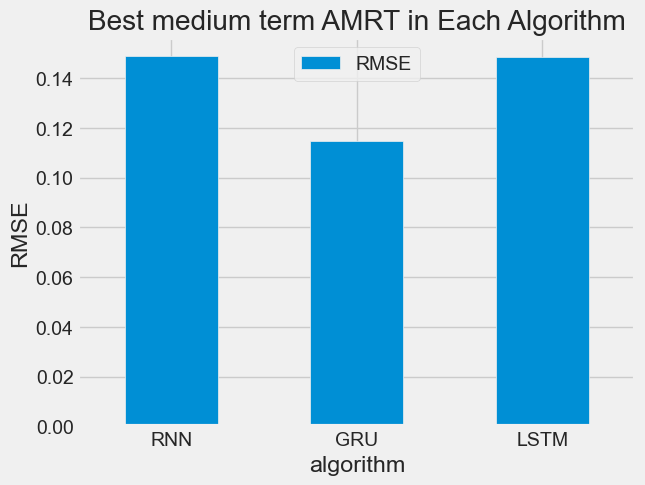

In [1070]:
data_tuning_medium_AMRT = pd.concat([minimum_config_RNN_AMRT, minimum_config_GRU_AMRT, minimum_config_LSTM_AMRT]).rename(columns={"rmse_norm" : "RMSE" })
bar_AMRT_tuning_medium = data_tuning_medium_AMRT.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best medium term AMRT in Each Algorithm")
data_tuning_medium_AMRT

239 133
5/5 [==============================] - 1s 9ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

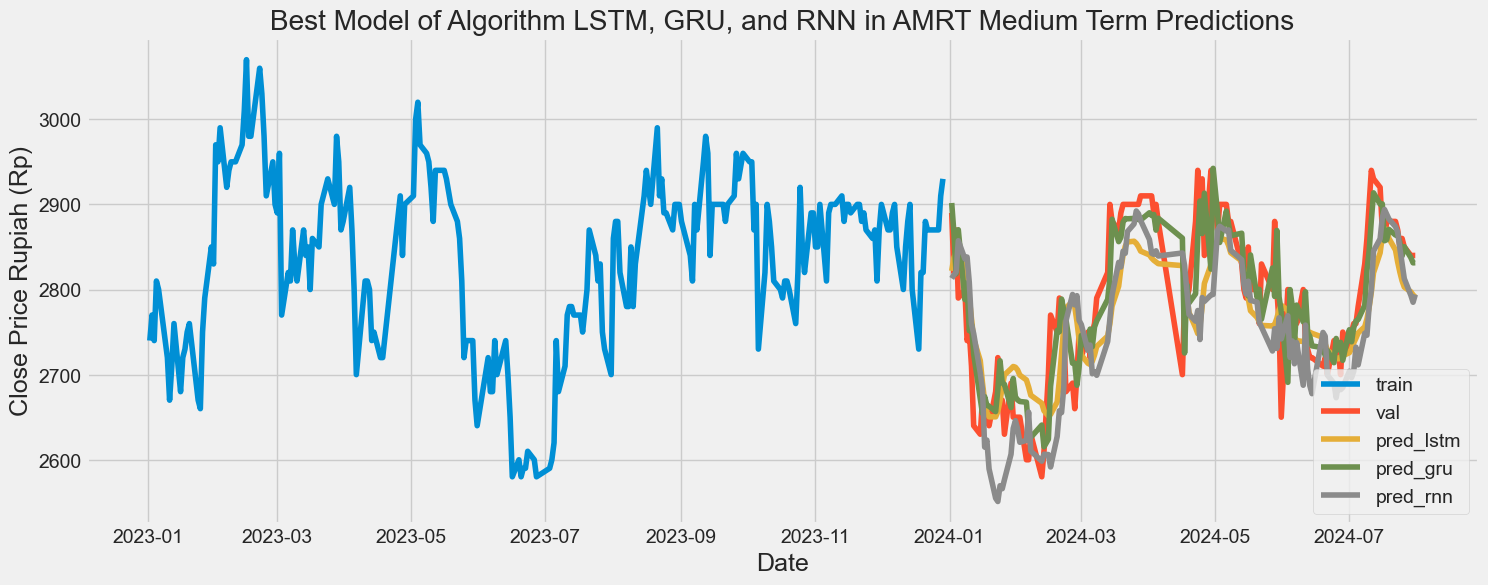

In [1297]:
rnn_best = ['adam', 64, 50, 100] 
gru_best =['adam', 32, 100, 50]
lstm_best = ['rmsprop', 32, 50, 100]
show_all_algorithm(AMRT, "med", "2023-01-01", "2023-12-31", "2024-07-31", 20, "AMRT", lstm_best, gru_best, rnn_best)

In [1071]:
#Best Model for AMRT medium
minimum_AMRT_medium = data_tuning_medium_AMRT["RMSE"].min()
minimum_config_AMRT_medium = data_tuning_medium_AMRT[data_tuning_medium_AMRT["RMSE"] == minimum_AMRT_medium]
minimum_config_AMRT_medium

stock    term algorithm       rmse      RMSE  epoch  unit optimizer  \
238  AMRT  medium       GRU  51.964243  0.114878    100    50      adam   

     batch_size  
238          32

239 133
5/5 [==============================] - 1s 14ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


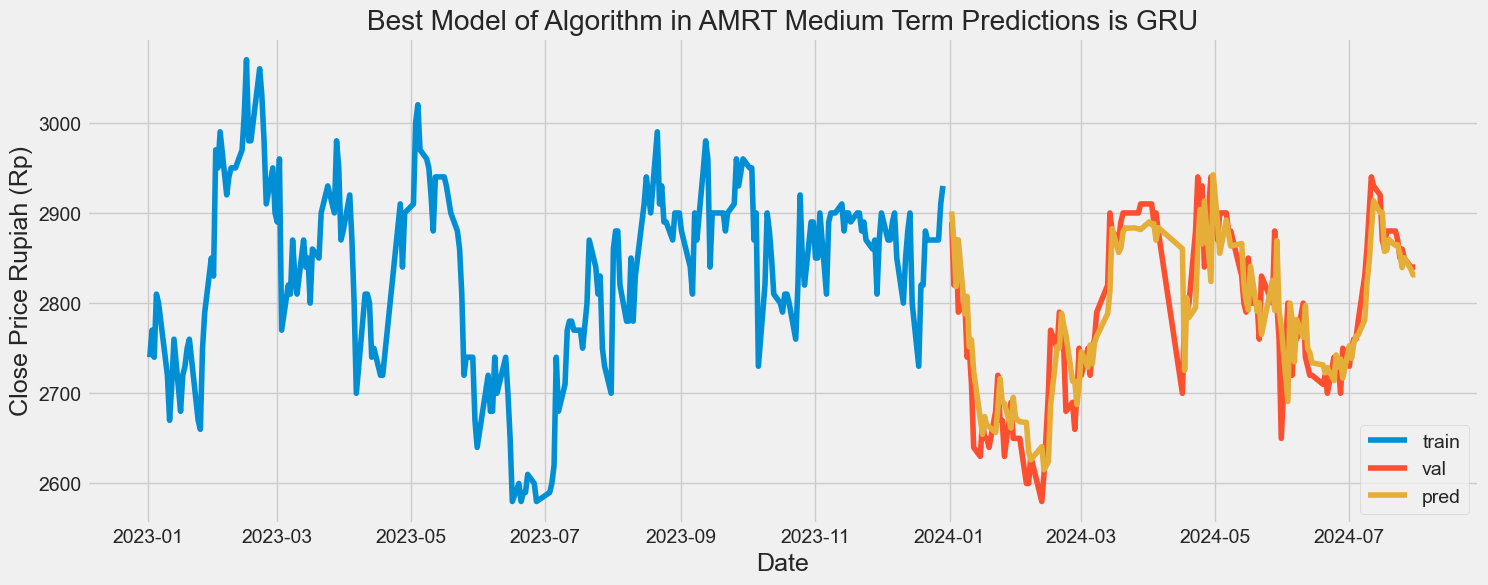

In [1255]:
show_each_algorithm(AMRT, "med","2023-01-01", "2023-12-31", "2024-07-31", 20, "AMRT", "gru", "adam", 32, 100, 50)

### ADRO

In [1072]:
data_ADRO_medium = model_medium[model_medium["stock"] == "ADRO"]
data_ADRO_medium.head()

stock    term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
6   ADRO  medium      LSTM  109.046845   0.123917     50    50   rmsprop   
7   ADRO  medium       GRU  108.079270   0.120305     50    50   rmsprop   
8   ADRO  medium       RNN  122.510251   0.139216     50    50   rmsprop   
24  ADRO  medium      LSTM   94.855627   0.107790     50    50      adam   
25  ADRO  medium       GRU   61.827341   0.070258     50    50      adam   

    batch_size  
6           32  
7           32  
8           32  
24          32  
25          32

#### LSTM

In [1073]:
data_ADRO_LSTM_medium = data_ADRO_medium[data_ADRO_medium["algorithm"] == "LSTM"]
minimum_LSTM_ADRO = data_ADRO_LSTM_medium["rmse_norm"].min()
minimum_config_LSTM_ADRO = data_ADRO_LSTM_medium[data_ADRO_LSTM_medium["rmse_norm"] == minimum_LSTM_ADRO]
minimum_config_LSTM_ADRO

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
240  ADRO  medium      LSTM  78.891491   0.089649    100    50      adam   

     batch_size  
240          32

#### GRU

In [1074]:
data_ADRO_GRU_medium = data_ADRO_medium[data_ADRO_medium["algorithm"] == "GRU"]
minimum_GRU_ADRO = data_ADRO_GRU_medium["rmse_norm"].min()
minimum_config_GRU_ADRO = data_ADRO_GRU_medium[data_ADRO_GRU_medium["rmse_norm"] == minimum_GRU_ADRO]
minimum_config_GRU_ADRO

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
241  ADRO  medium       GRU  43.047363   0.048917    100    50      adam   

     batch_size  
241          32

#### RNN

In [1075]:
data_ADRO_RNN_medium = data_ADRO_medium[data_ADRO_medium["algorithm"] == "RNN"]
minimum_RNN_ADRO = data_ADRO_RNN_medium["rmse_norm"].min()
minimum_config_RNN_ADRO = data_ADRO_RNN_medium[data_ADRO_RNN_medium["rmse_norm"] == minimum_RNN_ADRO]
minimum_config_RNN_ADRO

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
242  ADRO  medium       RNN  72.485672    0.08237    100    50      adam   

     batch_size  
242          32

#### Best Model

stock    term algorithm       rmse      RMSE  epoch  unit optimizer  \
242  ADRO  medium       RNN  72.485672  0.082370    100    50      adam   
241  ADRO  medium       GRU  43.047363  0.048917    100    50      adam   
240  ADRO  medium      LSTM  78.891491  0.089649    100    50      adam   

     batch_size  
242          32  
241          32  
240          32

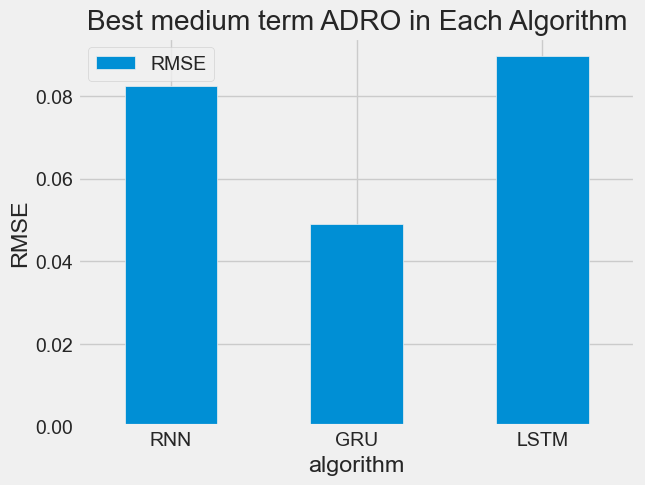

In [1076]:
data_tuning_medium_ADRO = pd.concat([minimum_config_RNN_ADRO, minimum_config_GRU_ADRO, minimum_config_LSTM_ADRO]).rename(columns={"rmse_norm" : "RMSE" })
bar_ADRO_tuning_medium = data_tuning_medium_ADRO.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best medium term ADRO in Each Algorithm")
data_tuning_medium_ADRO

239 133
5/5 [==============================] - 0s 9ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

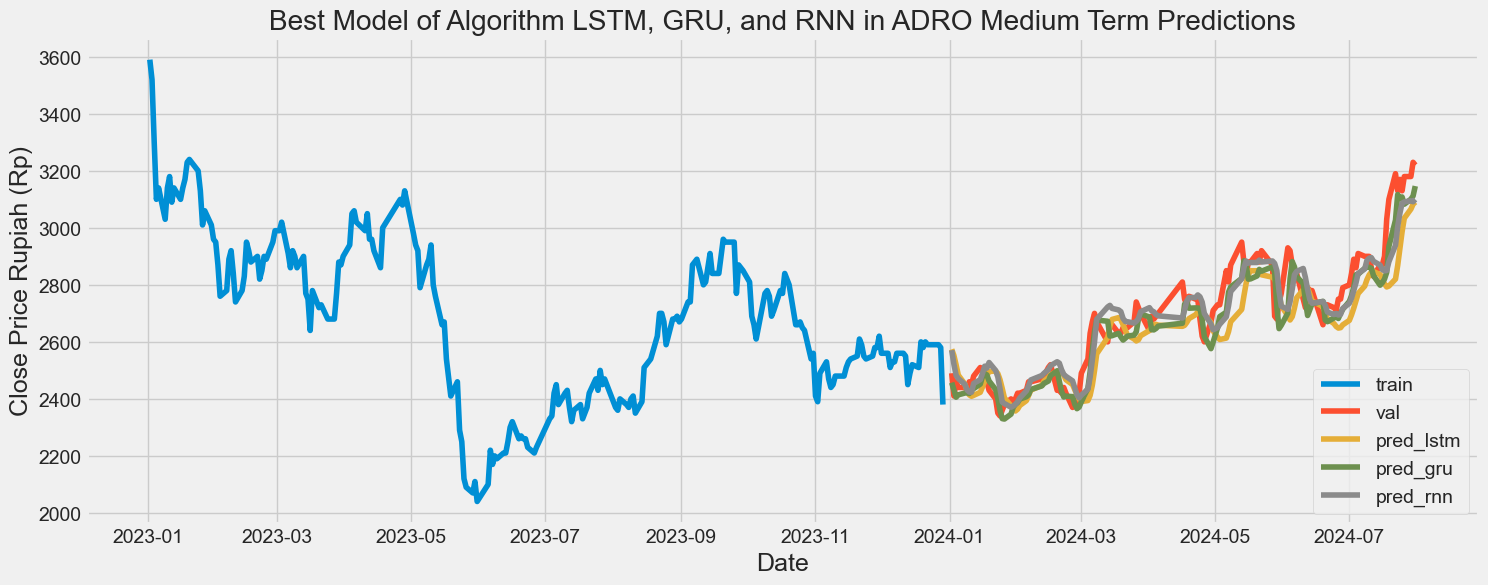

In [1283]:
rnn_best = ['adam', 32, 100, 50] 
gru_best =['adam', 32, 100, 50]
lstm_best = ['rmsprop', 32, 100, 50]
show_all_algorithm(ADRO, "med", "2023-01-01", "2023-12-31", "2024-07-31", 20, "ADRO", lstm_best, gru_best, rnn_best)

In [1077]:
#Best Model for ADRO medium
minimum_ADRO_medium = data_tuning_medium_ADRO["RMSE"].min()
minimum_config_ADRO_medium = data_tuning_medium_ADRO[data_tuning_medium_ADRO["RMSE"] == minimum_ADRO_medium]
minimum_config_ADRO_medium

stock    term algorithm       rmse      RMSE  epoch  unit optimizer  \
241  ADRO  medium       GRU  43.047363  0.048917    100    50      adam   

     batch_size  
241          32

239 133
5/5 [==============================] - 2s 14ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


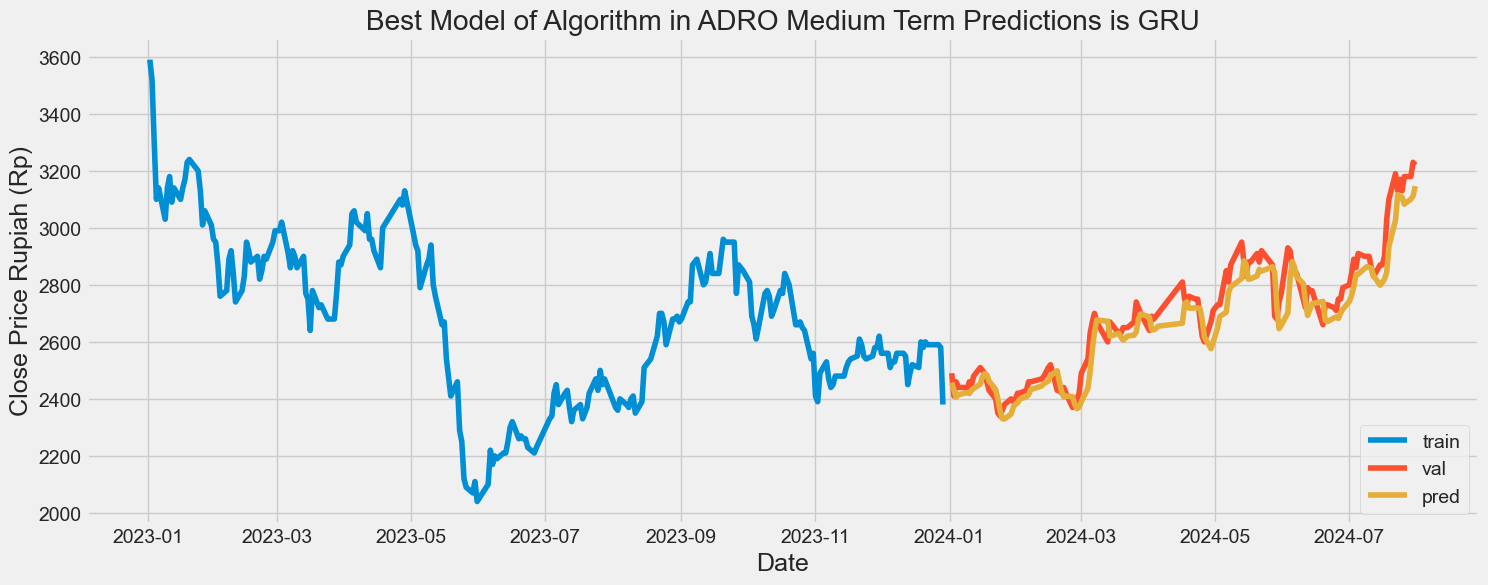

In [1257]:
show_each_algorithm(ADRO, "med","2023-01-01", "2023-12-31", "2024-07-31", 20, "ADRO", "gru", "adam", 32, 100, 50)

### MAPI

In [1078]:
data_MAPI_medium = model_medium[model_medium["stock"] == "MAPI"]
data_MAPI_medium.head()

stock    term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
9   MAPI  medium      LSTM  120.481261   0.161720     50    50   rmsprop   
10  MAPI  medium       GRU   77.672137   0.104258     50    50   rmsprop   
11  MAPI  medium       RNN   73.108124   0.097060     50    50   rmsprop   
27  MAPI  medium      LSTM   95.894473   0.128717     50    50      adam   
28  MAPI  medium       GRU   59.086599   0.079311     50    50      adam   

    batch_size  
9           32  
10          32  
11          32  
27          32  
28          32

#### LSTM

In [1079]:
data_MAPI_LSTM_medium = data_MAPI_medium[data_MAPI_medium["algorithm"] == "LSTM"]
minimum_LSTM_MAPI = data_MAPI_LSTM_medium["rmse_norm"].min()
minimum_config_LSTM_MAPI = data_MAPI_LSTM_medium[data_MAPI_LSTM_medium["rmse_norm"] == minimum_LSTM_MAPI]
minimum_config_LSTM_MAPI

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
135  MAPI  medium      LSTM  84.325216   0.113188     50   100      adam   

     batch_size  
135          32

#### GRU

In [1080]:
data_MAPI_GRU_medium = data_MAPI_medium[data_MAPI_medium["algorithm"] == "GRU"]
minimum_GRU_MAPI = data_MAPI_GRU_medium["rmse_norm"].min()
minimum_config_GRU_MAPI = data_MAPI_GRU_medium[data_MAPI_GRU_medium["rmse_norm"] == minimum_GRU_MAPI]
minimum_config_GRU_MAPI

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
244  MAPI  medium       GRU  47.289038   0.063475    100    50      adam   

     batch_size  
244          32

#### RNN

In [1081]:
data_MAPI_RNN_medium = data_MAPI_medium[data_MAPI_medium["algorithm"] == "RNN"]
minimum_RNN_MAPI = data_MAPI_RNN_medium["rmse_norm"].min()
minimum_config_RNN_MAPI = data_MAPI_RNN_medium[data_MAPI_RNN_medium["rmse_norm"] == minimum_RNN_MAPI]
minimum_config_RNN_MAPI

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
245  MAPI  medium       RNN  55.750973   0.074834    100    50      adam   

     batch_size  
245          32

#### Best Model

stock    term algorithm       rmse      RMSE  epoch  unit optimizer  \
245  MAPI  medium       RNN  55.750973  0.074834    100    50      adam   
244  MAPI  medium       GRU  47.289038  0.063475    100    50      adam   
135  MAPI  medium      LSTM  84.325216  0.113188     50   100      adam   

     batch_size  
245          32  
244          32  
135          32

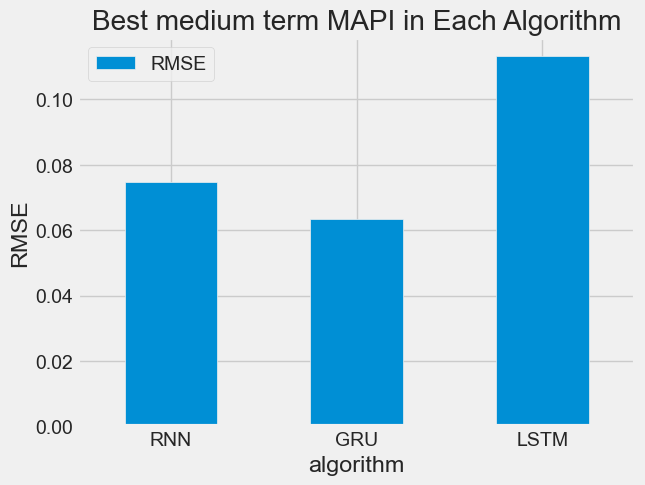

In [1082]:
data_tuning_medium_MAPI = pd.concat([minimum_config_RNN_MAPI, minimum_config_GRU_MAPI, minimum_config_LSTM_MAPI]).rename(columns={"rmse_norm" : "RMSE" })
bar_MAPI_tuning_medium = data_tuning_medium_MAPI.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best medium term MAPI in Each Algorithm")
data_tuning_medium_MAPI

239 133
5/5 [==============================] - 0s 8ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

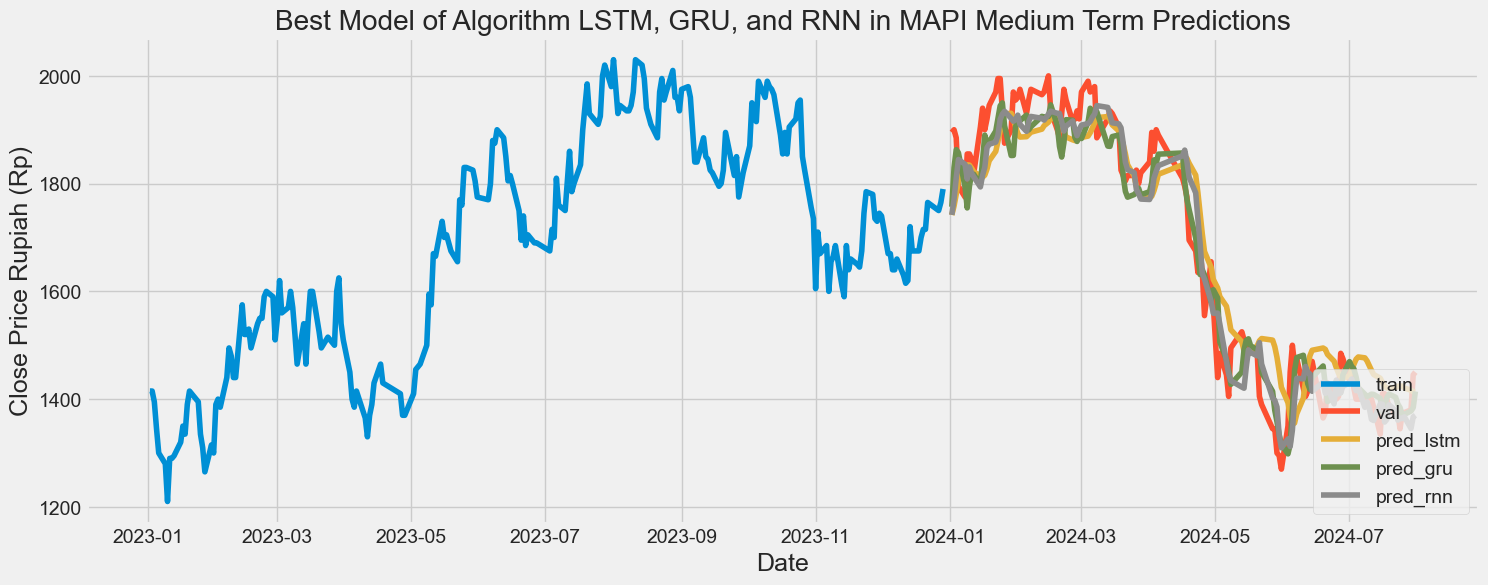

In [1284]:
rnn_best = ['adam', 32, 100, 50] 
gru_best =['adam', 32, 100, 50]
lstm_best = ['adam', 32, 50, 100]
show_all_algorithm(MAPI, "med", "2023-01-01", "2023-12-31", "2024-07-31", 20, "MAPI", lstm_best, gru_best, rnn_best)

In [1083]:
#Best Model for MAPI medium
minimum_MAPI_medium = data_tuning_medium_MAPI["RMSE"].min()
minimum_config_MAPI_medium = data_tuning_medium_MAPI[data_tuning_medium_MAPI["RMSE"] == minimum_MAPI_medium]
minimum_config_MAPI_medium

stock    term algorithm       rmse      RMSE  epoch  unit optimizer  \
244  MAPI  medium       GRU  47.289038  0.063475    100    50      adam   

     batch_size  
244          32

239 133
5/5 [==============================] - 1s 16ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


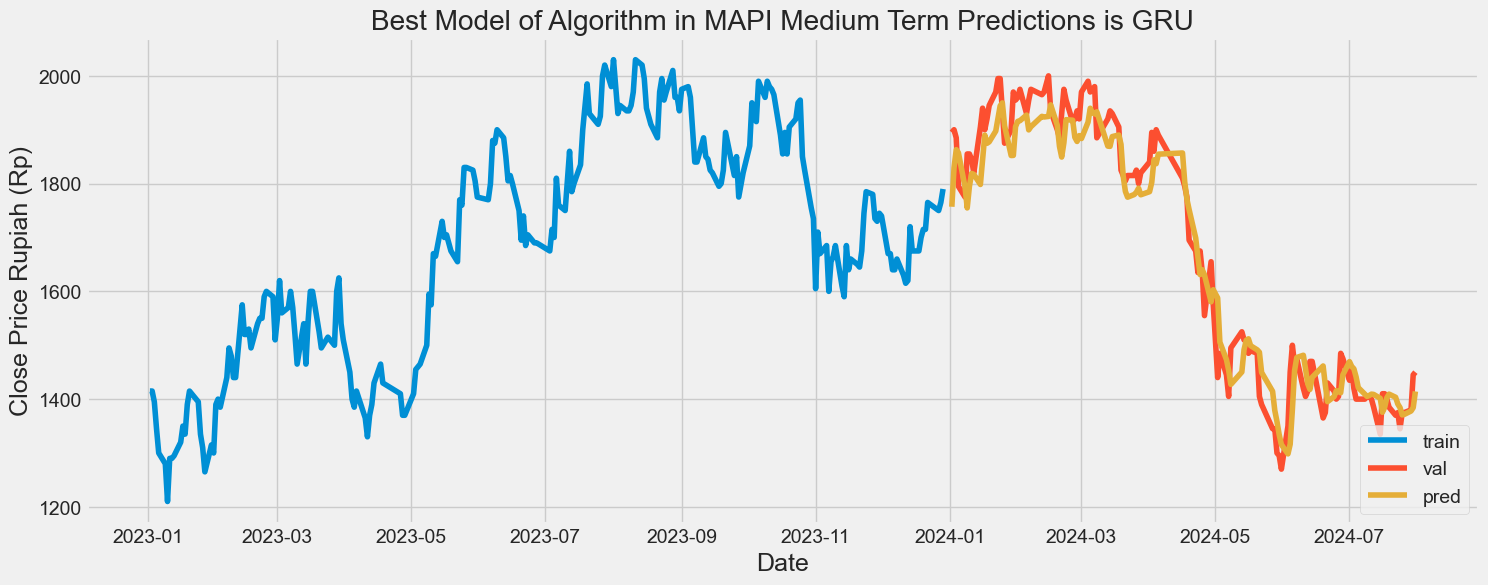

In [1258]:
show_each_algorithm(MAPI, "med","2023-01-01", "2023-12-31", "2024-07-31", 20, "MAPI", "gru", "adam", 32, 100, 50)

### KLBF

In [1084]:
data_KLBF_medium = model_medium[model_medium["stock"] == "KLBF"]
data_KLBF_medium.head()

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
12  KLBF  medium      LSTM  45.963305   0.193439     50    50   rmsprop   
13  KLBF  medium       GRU  35.335051   0.151260     50    50   rmsprop   
14  KLBF  medium       RNN  96.876890   0.239439     50    50   rmsprop   
30  KLBF  medium      LSTM  44.925541   0.197604     50    50      adam   
31  KLBF  medium       GRU  37.271195   0.158026     50    50      adam   

    batch_size  
12          32  
13          32  
14          32  
30          32  
31          32

#### LSTM

In [1085]:
data_KLBF_LSTM_medium = data_KLBF_medium[data_KLBF_medium["algorithm"] == "LSTM"]
minimum_LSTM_KLBF = data_KLBF_LSTM_medium["rmse_norm"].min()
minimum_config_LSTM_KLBF = data_KLBF_LSTM_medium[data_KLBF_LSTM_medium["rmse_norm"] == minimum_LSTM_KLBF]
minimum_config_LSTM_KLBF

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
228  KLBF  medium      LSTM  38.657586   0.171811    100    50   rmsprop   

     batch_size  
228          32

#### GRU

In [1086]:
data_KLBF_GRU_medium = data_KLBF_medium[data_KLBF_medium["algorithm"] == "GRU"]
minimum_GRU_KLBF = data_KLBF_GRU_medium["rmse_norm"].min()
minimum_config_GRU_KLBF = data_KLBF_GRU_medium[data_KLBF_GRU_medium["rmse_norm"] == minimum_GRU_KLBF]
minimum_config_GRU_KLBF

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
121  KLBF  medium       GRU  31.111165   0.138272     50   100   rmsprop   

     batch_size  
121          32

#### RNN

In [1087]:
data_KLBF_RNN_medium = data_KLBF_medium[data_KLBF_medium["algorithm"] == "RNN"]
minimum_RNN_KLBF = data_KLBF_RNN_medium["rmse_norm"].min()
minimum_config_RNN_KLBF = data_KLBF_RNN_medium[data_KLBF_RNN_medium["rmse_norm"] == minimum_RNN_KLBF]
minimum_config_RNN_KLBF

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
284  KLBF  medium       RNN  26.958453   0.119815    100    50   rmsprop   

     batch_size  
284          64

#### Best Model

stock    term algorithm       rmse      RMSE  epoch  unit optimizer  \
284  KLBF  medium       RNN  26.958453  0.119815    100    50   rmsprop   
121  KLBF  medium       GRU  31.111165  0.138272     50   100   rmsprop   
228  KLBF  medium      LSTM  38.657586  0.171811    100    50   rmsprop   

     batch_size  
284          64  
121          32  
228          32

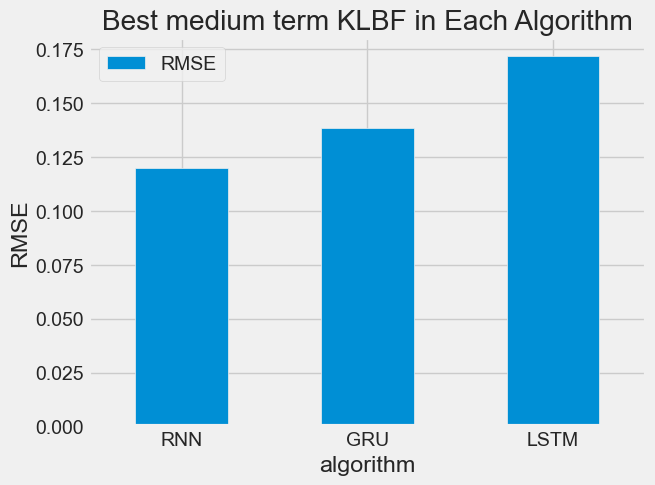

In [1088]:
data_tuning_medium_KLBF = pd.concat([minimum_config_RNN_KLBF, minimum_config_GRU_KLBF, minimum_config_LSTM_KLBF]).rename(columns={"rmse_norm" : "RMSE" })
bar_KLBF_tuning_medium = data_tuning_medium_KLBF.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best medium term KLBF in Each Algorithm")
data_tuning_medium_KLBF

239 133
5/5 [==============================] - 0s 7ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

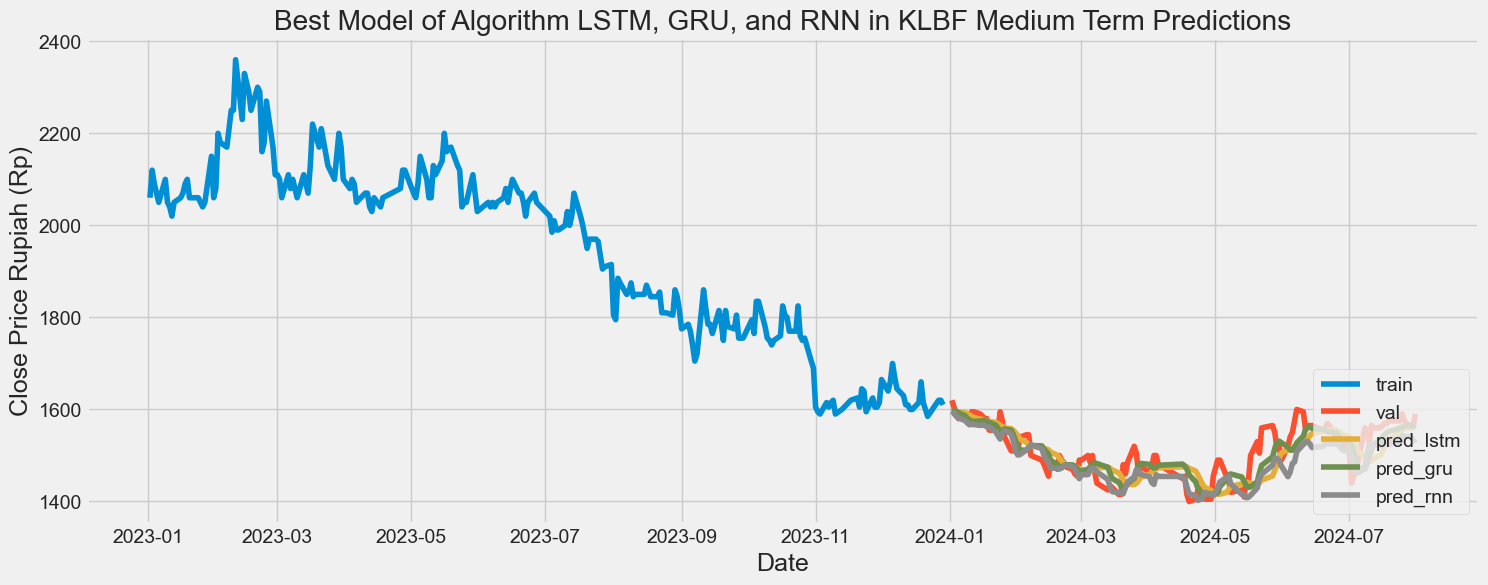

In [1285]:
rnn_best = ['rmsprop', 64, 100, 50] 
gru_best =['rmsprop', 32, 50, 100]
lstm_best = ['rmsprop', 32, 100, 50]
show_all_algorithm(KLBF, "med", "2023-01-01", "2023-12-31", "2024-07-31", 20, "KLBF", lstm_best, gru_best, rnn_best)

In [1089]:
#Best Model for KLBF medium
minimum_KLBF_medium = data_tuning_medium_KLBF["RMSE"].min()
minimum_config_KLBF_medium = data_tuning_medium_KLBF[data_tuning_medium_KLBF["RMSE"] == minimum_KLBF_medium]
minimum_config_KLBF_medium

stock    term algorithm       rmse      RMSE  epoch  unit optimizer  \
284  KLBF  medium       RNN  26.958453  0.119815    100    50   rmsprop   

     batch_size  
284          64

239 133
5/5 [==============================] - 1s 9ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


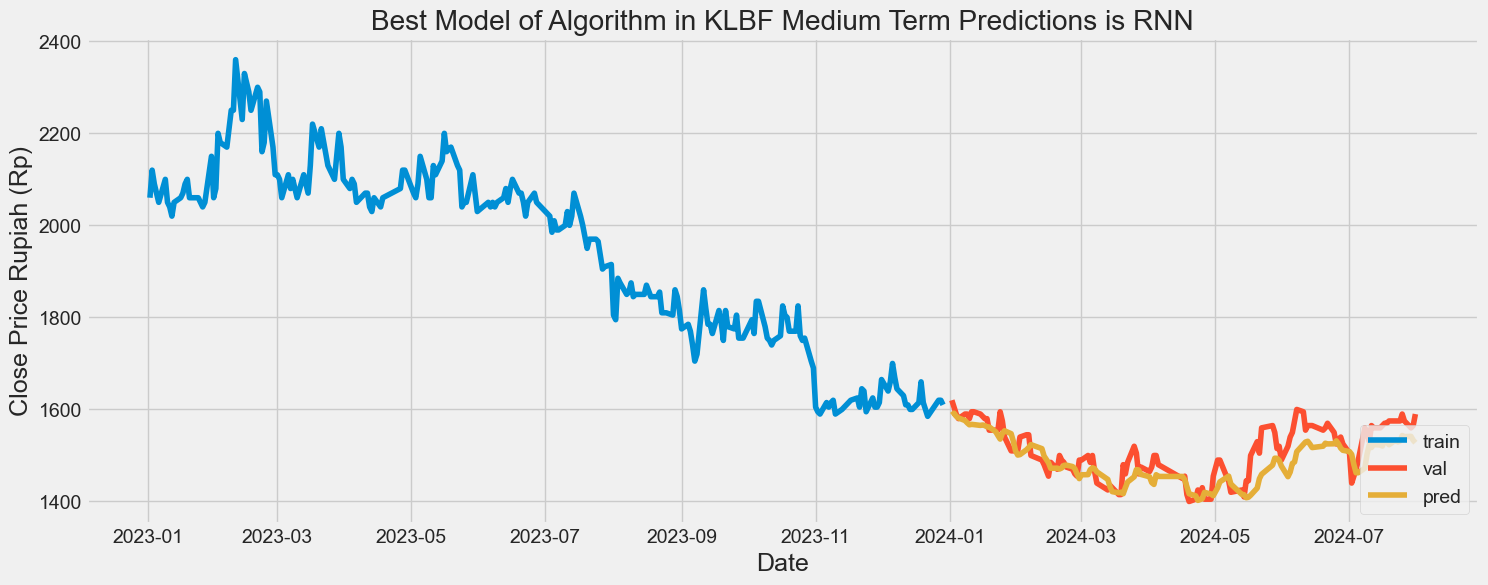

In [1265]:
show_each_algorithm(KLBF, "med","2023-01-01", "2023-12-31", "2024-07-31", 20, "KLBF", "rnn", "rmsprop", 64, 100, 50)

### TLKM

In [1090]:
data_TLKM_medium = model_medium[model_medium["stock"] == "TLKM"]
data_TLKM_medium.head()

stock    term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
15  TLKM  medium      LSTM  191.552219   0.130775     50    50   rmsprop   
16  TLKM  medium       GRU  136.033439   0.093174     50    50   rmsprop   
17  TLKM  medium       RNN  167.988073   0.110951     50    50   rmsprop   
33  TLKM  medium      LSTM  187.640462   0.128521     50    50      adam   
34  TLKM  medium       GRU  115.990777   0.079420     50    50      adam   

    batch_size  
15          32  
16          32  
17          32  
33          32  
34          32

#### LSTM

In [1091]:
data_TLKM_LSTM_medium = data_TLKM_medium[data_TLKM_medium["algorithm"] == "LSTM"]
minimum_LSTM_TLKM = data_TLKM_LSTM_medium["rmse_norm"].min()
minimum_config_LSTM_TLKM = data_TLKM_LSTM_medium[data_TLKM_LSTM_medium["rmse_norm"] == minimum_LSTM_TLKM]
minimum_config_LSTM_TLKM

stock    term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
231  TLKM  medium      LSTM  144.683357   0.099098    100    50   rmsprop   

     batch_size  
231          32

#### GRU

In [1092]:
data_TLKM_GRU_medium = data_TLKM_medium[data_TLKM_medium["algorithm"] == "GRU"]
minimum_GRU_TLKM = data_TLKM_GRU_medium["rmse_norm"].min()
minimum_config_GRU_TLKM = data_TLKM_GRU_medium[data_TLKM_GRU_medium["rmse_norm"] == minimum_GRU_TLKM]
minimum_config_GRU_TLKM

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
250  TLKM  medium       GRU  92.271924   0.061742    100    50      adam   

     batch_size  
250          32

#### RNN

In [1093]:
data_TLKM_RNN_medium = data_TLKM_medium[data_TLKM_medium["algorithm"] == "RNN"]
minimum_RNN_TLKM = data_TLKM_RNN_medium["rmse_norm"].min()
minimum_config_RNN_TLKM = data_TLKM_RNN_medium[data_TLKM_RNN_medium["rmse_norm"] == minimum_RNN_TLKM]
minimum_config_RNN_TLKM

stock    term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
233  TLKM  medium       RNN  79.523307   0.054468    100    50   rmsprop   

     batch_size  
233          32

#### Best Model

stock    term algorithm        rmse      RMSE  epoch  unit optimizer  \
233  TLKM  medium       RNN   79.523307  0.054468    100    50   rmsprop   
250  TLKM  medium       GRU   92.271924  0.061742    100    50      adam   
231  TLKM  medium      LSTM  144.683357  0.099098    100    50   rmsprop   

     batch_size  
233          32  
250          32  
231          32

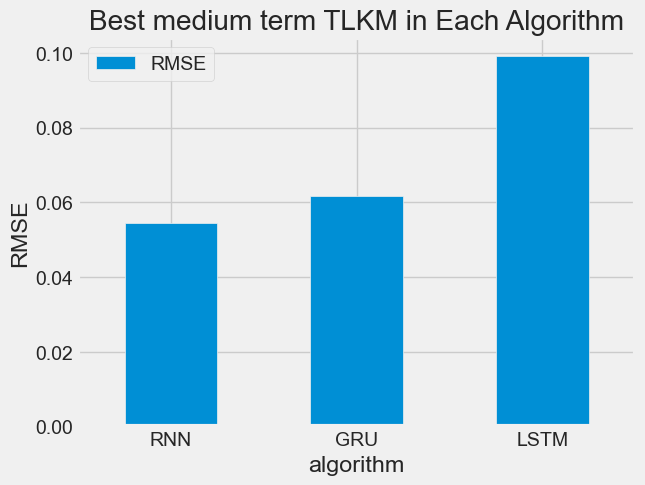

In [1094]:
data_tuning_medium_TLKM = pd.concat([minimum_config_RNN_TLKM, minimum_config_GRU_TLKM, minimum_config_LSTM_TLKM]).rename(columns={"rmse_norm" : "RMSE" })
bar_TLKM_tuning_medium = data_tuning_medium_TLKM.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best medium term TLKM in Each Algorithm")
data_tuning_medium_TLKM

239 133
5/5 [==============================] - 1s 8ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

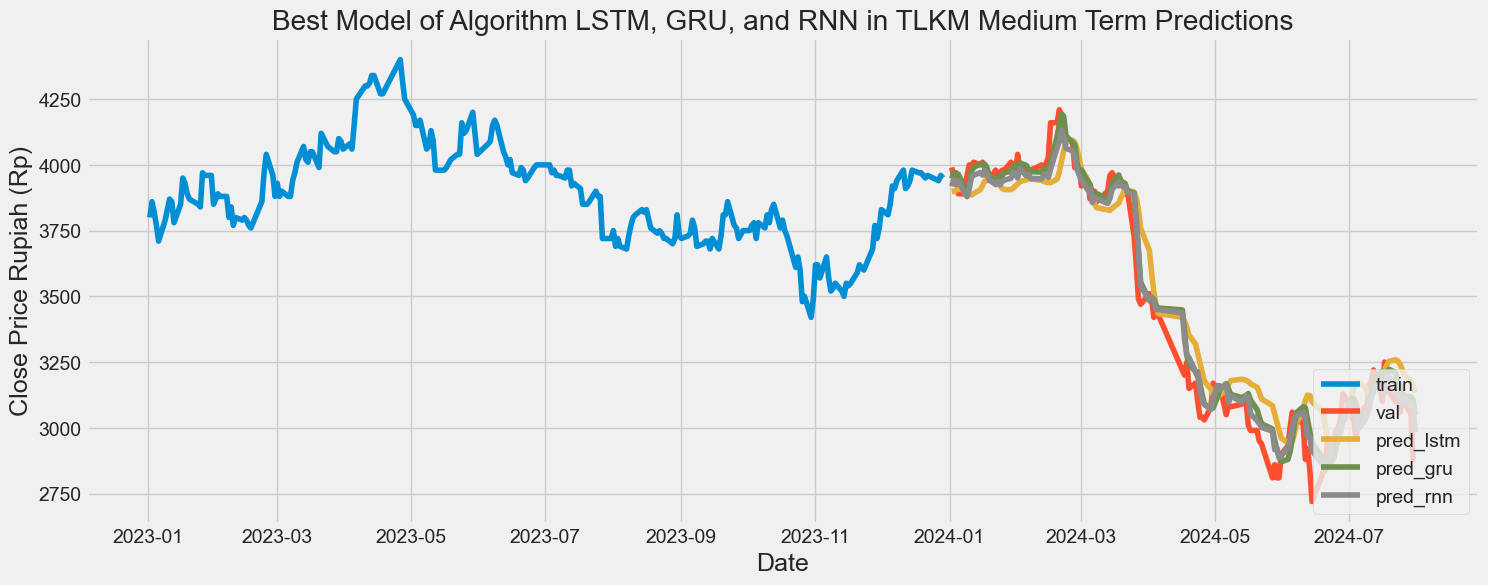

In [1286]:
rnn_best = ['rmsprop', 32, 100, 50] 
gru_best =['adam', 32, 100, 50]
lstm_best = ['rmsprop', 32, 100, 50]
show_all_algorithm(TLKM, "med", "2023-01-01", "2023-12-31", "2024-07-31", 20, "TLKM", lstm_best, gru_best, rnn_best)

In [1095]:
#Best Model for TLKM medium
minimum_TLKM_medium = data_tuning_medium_TLKM["RMSE"].min()
minimum_config_TLKM_medium = data_tuning_medium_TLKM[data_tuning_medium_TLKM["RMSE"] == minimum_TLKM_medium]
minimum_config_TLKM_medium

stock    term algorithm       rmse      RMSE  epoch  unit optimizer  \
233  TLKM  medium       RNN  79.523307  0.054468    100    50   rmsprop   

     batch_size  
233          32

239 133
5/5 [==============================] - 1s 9ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


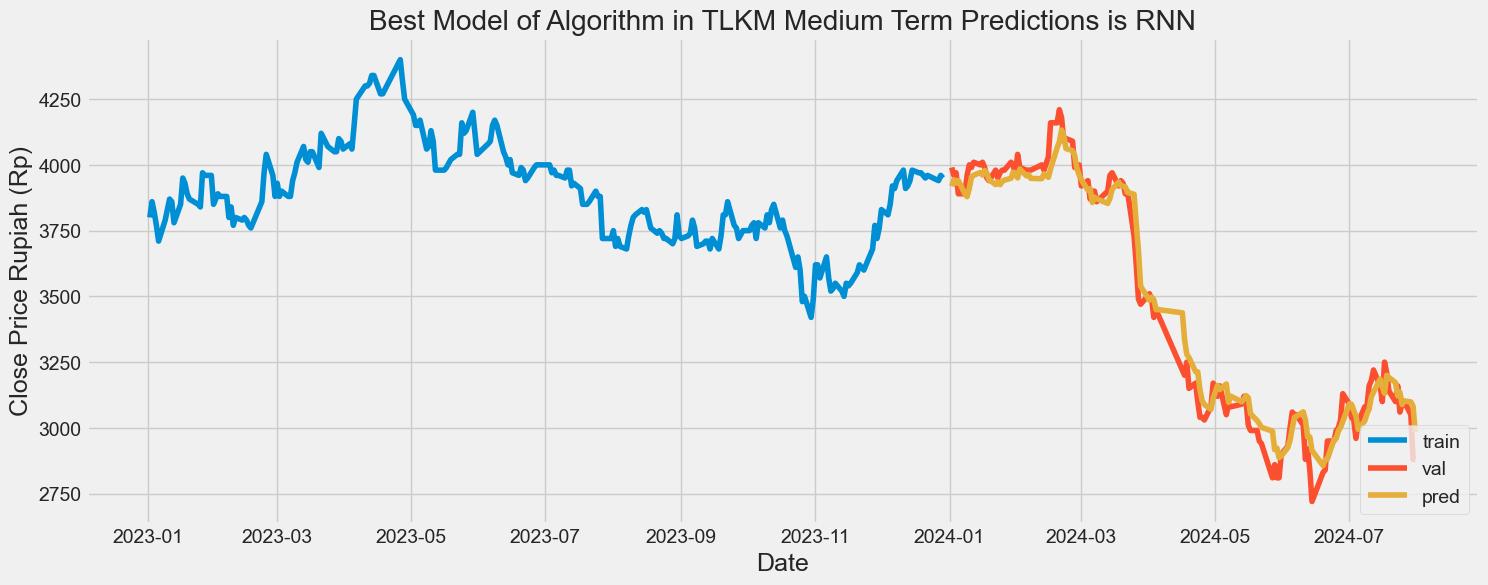

In [1264]:
show_each_algorithm(TLKM, "med","2023-01-01", "2023-12-31", "2024-07-31", 20, "TLKM", "rnn", "rmsprop", 32, 100, 50)

### Best Model for Each Stock in Medium Term

stock    term algorithm        rmse      RMSE  epoch  unit optimizer  \
235  ASII  medium       GRU  104.863653  0.077229    100    50      adam   
238  AMRT  medium       GRU   51.964243  0.114878    100    50      adam   
241  ADRO  medium       GRU   43.047363  0.048917    100    50      adam   
244  MAPI  medium       GRU   47.289038  0.063475    100    50      adam   
284  KLBF  medium       RNN   26.958453  0.119815    100    50   rmsprop   
233  TLKM  medium       RNN   79.523307  0.054468    100    50   rmsprop   

     batch_size  
235          32  
238          32  
241          32  
244          32  
284          64  
233          32

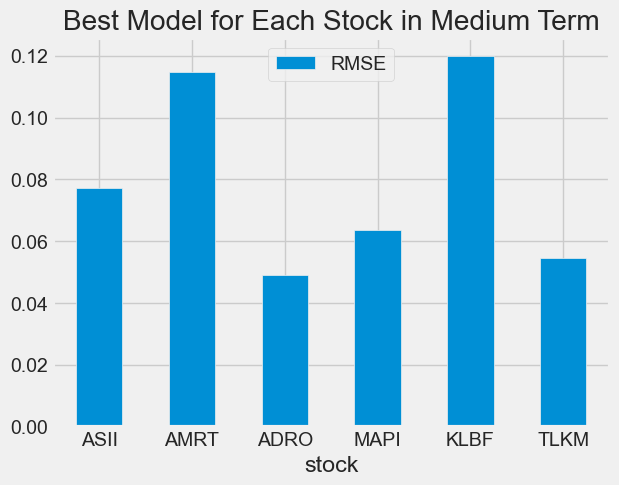

In [1287]:
best_data_medium = pd.concat([minimum_config_ASII_medium,
                            minimum_config_AMRT_medium,
                            minimum_config_ADRO_medium,
                            minimum_config_MAPI_medium,
                            minimum_config_KLBF_medium,
                            minimum_config_TLKM_medium]
                            )
bar_tuning_medium = best_data_medium.plot.bar(x='stock', y=['RMSE'], rot=0, title="Best Model for Each Stock in Medium Term")
best_data_medium

## Short Term
Data used is:
- Train : January - September 2023 (9 month)
- Test : Oktober - Desember 2023 (3 month)

In [1097]:
model_short = pd.read_csv("../result_paper_tuning/result_short_tuning.csv")
model_short.head()

C:\Users\ThinkPad\AppData\Roaming\Python\Python311\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


stock   term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
0  ASII  short      LSTM  163.222732   0.192027     50    50   rmsprop   
1  ASII  short       GRU  105.502766   0.124121     50    50   rmsprop   
2  ASII  short       RNN  198.967726   0.194868     50    50   rmsprop   
3  AMRT  short      LSTM   75.524925   0.187020     50    50   rmsprop   
4  AMRT  short       GRU   55.210275   0.138026     50    50   rmsprop   

   batch_size  
0          32  
1          32  
2          32  
3          32  
4          32

### ASII

In [1098]:
data_ASII_short = model_short[model_short["stock"] == "ASII"]
data_ASII_short.head()

stock   term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
0   ASII  short      LSTM  163.222732   0.192027     50    50   rmsprop   
1   ASII  short       GRU  105.502766   0.124121     50    50   rmsprop   
2   ASII  short       RNN  198.967726   0.194868     50    50   rmsprop   
18  ASII  short      LSTM  183.632836   0.214606     50    50      adam   
19  ASII  short       GRU  143.272639   0.168556     50    50      adam   

    batch_size  
0           32  
1           32  
2           32  
18          32  
19          32

#### LSTM

In [1099]:
data_ASII_LSTM_short = data_ASII_short[data_ASII_short["algorithm"] == "LSTM"]
minimum_LSTM_ASII = data_ASII_LSTM_short["rmse_norm"].min()
minimum_config_LSTM_ASII = data_ASII_LSTM_short[data_ASII_LSTM_short["rmse_norm"] == minimum_LSTM_ASII]
minimum_config_LSTM_ASII

stock   term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
324  ASII  short      LSTM  135.467119   0.159373    100   100   rmsprop   

     batch_size  
324          32

#### GRU

In [1100]:
data_ASII_GRU_short = data_ASII_short[data_ASII_short["algorithm"] == "GRU"]
minimum_GRU_ASII = data_ASII_GRU_short["rmse_norm"].min()
minimum_config_GRU_ASII = data_ASII_GRU_short[data_ASII_GRU_short["rmse_norm"] == minimum_GRU_ASII]
minimum_config_GRU_ASII

stock   term algorithm      rmse  rmse_norm  epoch  unit optimizer  \
343  ASII  short       GRU  79.44775   0.093468    100   100      adam   

     batch_size  
343          32

#### RNN

In [1101]:
data_ASII_RNN_short = data_ASII_short[data_ASII_short["algorithm"] == "RNN"]
minimum_RNN_ASII = data_ASII_RNN_short["rmse_norm"].min()
minimum_config_RNN_ASII = data_ASII_RNN_short[data_ASII_RNN_short["rmse_norm"] == minimum_RNN_ASII]
minimum_config_RNN_ASII

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
272  ASII  short       RNN  74.386256   0.087513    100    50   rmsprop   

     batch_size  
272          64

#### Best Model

stock   term algorithm        rmse      RMSE  epoch  unit optimizer  \
272  ASII  short       RNN   74.386256  0.087513    100    50   rmsprop   
343  ASII  short       GRU   79.447750  0.093468    100   100      adam   
324  ASII  short      LSTM  135.467119  0.159373    100   100   rmsprop   

     batch_size  
272          64  
343          32  
324          32

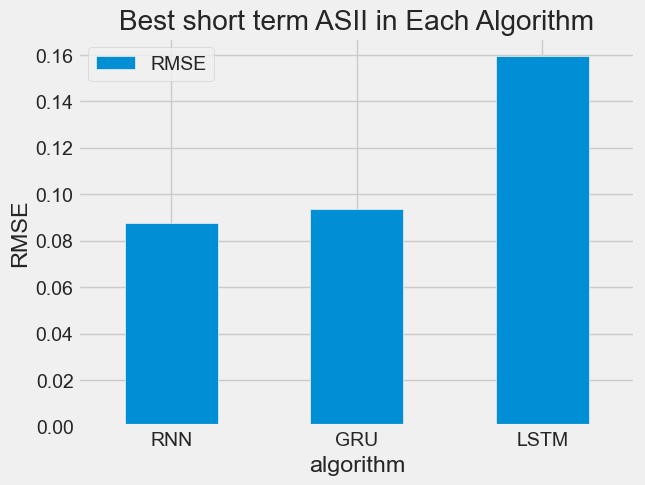

In [1102]:
data_tuning_short_ASII = pd.concat([minimum_config_RNN_ASII, minimum_config_GRU_ASII, minimum_config_LSTM_ASII]).rename(columns={"rmse_norm" : "RMSE" })
bar_ASII_tuning_short = data_tuning_short_ASII.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best short term ASII in Each Algorithm")
data_tuning_short_ASII

176 63
2/2 [==============================] - 0s 16ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

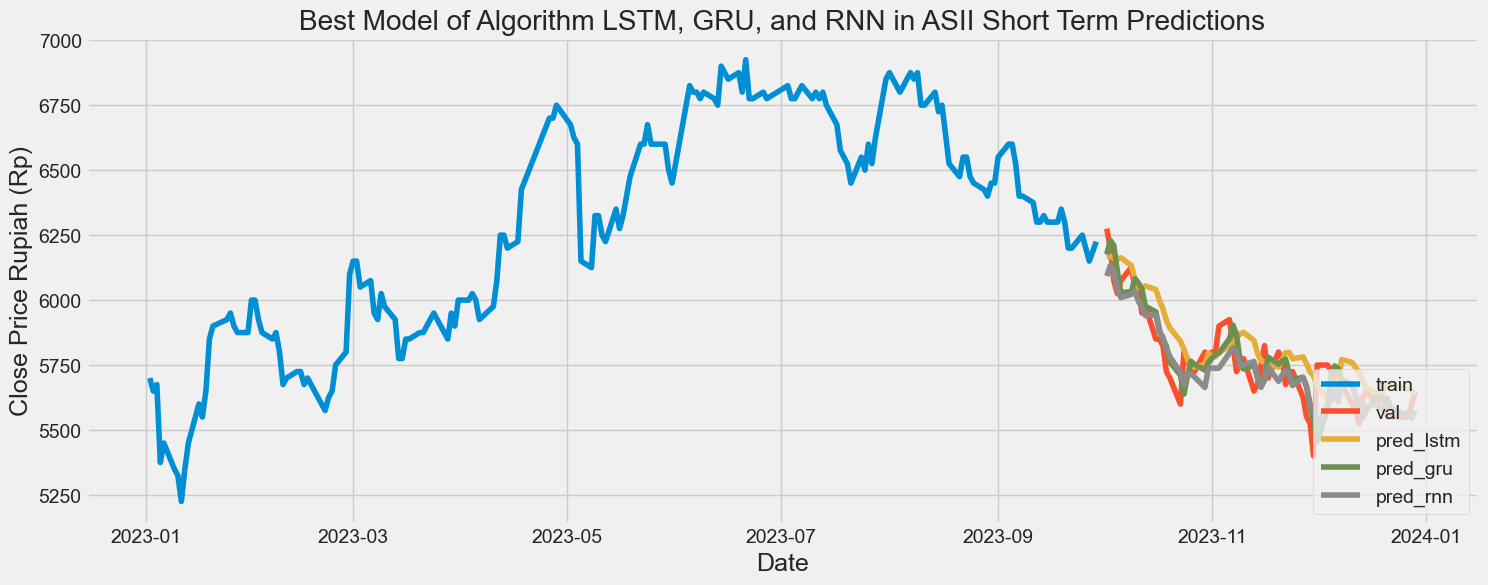

In [1294]:
rnn_best = ['rmsprop', 64, 100, 50] 
gru_best =['adam', 32, 100, 100]
lstm_best = ['rmsprop', 32, 100, 100]
show_all_algorithm(ASII, "short", "2023-01-01", "2023-09-30", "2023-12-31", 5, "ASII", lstm_best, gru_best, rnn_best)

In [1103]:
#Best Model for ASII short
minimum_ASII_short = data_tuning_short_ASII["RMSE"].min()
minimum_config_ASII_short = data_tuning_short_ASII[data_tuning_short_ASII["RMSE"] == minimum_ASII_short]
minimum_config_ASII_short

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
272  ASII  short       RNN  74.386256  0.087513    100    50   rmsprop   

     batch_size  
272          64

176 63
2/2 [==============================] - 1s 0s/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


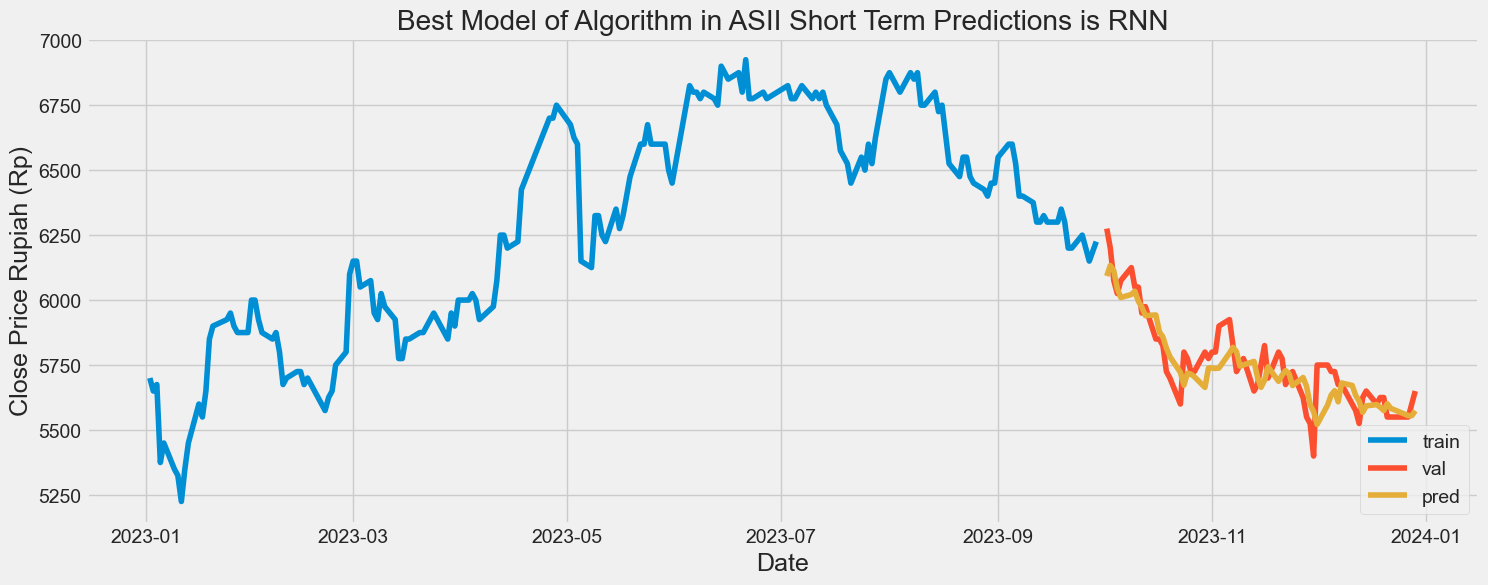

In [1263]:
show_each_algorithm(ASII, "short","2023-01-01", "2023-09-30", "2023-12-31", 5, "ASII", "rnn", "rmsprop", 64, 100, 50)

### AMRT

In [1104]:
data_AMRT_short = model_short[model_short["stock"] == "AMRT"]
data_AMRT_short.head()

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
3   AMRT  short      LSTM  75.524925   0.187020     50    50   rmsprop   
4   AMRT  short       GRU  55.210275   0.138026     50    50   rmsprop   
5   AMRT  short       RNN  77.281137   0.183477     50    50   rmsprop   
21  AMRT  short      LSTM  61.243017   0.153108     50    50      adam   
22  AMRT  short       GRU  70.009394   0.170426     50    50      adam   

    batch_size  
3           32  
4           32  
5           32  
21          32  
22          32

#### LSTM

In [1105]:
data_AMRT_LSTM_short = data_AMRT_short[data_AMRT_short["algorithm"] == "LSTM"]
minimum_LSTM_AMRT = data_AMRT_LSTM_short["rmse_norm"].min()
minimum_config_LSTM_AMRT = data_AMRT_LSTM_short[data_AMRT_LSTM_short["rmse_norm"] == minimum_LSTM_AMRT]
minimum_config_LSTM_AMRT

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
111  AMRT  short      LSTM  58.411374   0.146028     50   100   rmsprop   

     batch_size  
111          32

#### GRU

In [1106]:
data_AMRT_GRU_short = data_AMRT_short[data_AMRT_short["algorithm"] == "GRU"]
minimum_GRU_AMRT = data_AMRT_GRU_short["rmse_norm"].min()
minimum_config_GRU_AMRT = data_AMRT_GRU_short[data_AMRT_GRU_short["rmse_norm"] == minimum_GRU_AMRT]
minimum_config_GRU_AMRT

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
4  AMRT  short       GRU  55.210275   0.138026     50    50   rmsprop   

   batch_size  
4          32

#### RNN

In [1107]:
data_AMRT_RNN_short = data_AMRT_short[data_AMRT_short["algorithm"] == "RNN"]
minimum_RNN_AMRT = data_AMRT_RNN_short["rmse_norm"].min()
minimum_config_RNN_AMRT = data_AMRT_RNN_short[data_AMRT_RNN_short["rmse_norm"] == minimum_RNN_AMRT]
minimum_config_RNN_AMRT

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
293  AMRT  short       RNN  53.530476   0.133826    100    50      adam   

     batch_size  
293          64

#### Best Model

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
293  AMRT  short       RNN  53.530476  0.133826    100    50      adam   
4    AMRT  short       GRU  55.210275  0.138026     50    50   rmsprop   
111  AMRT  short      LSTM  58.411374  0.146028     50   100   rmsprop   

     batch_size  
293          64  
4            32  
111          32

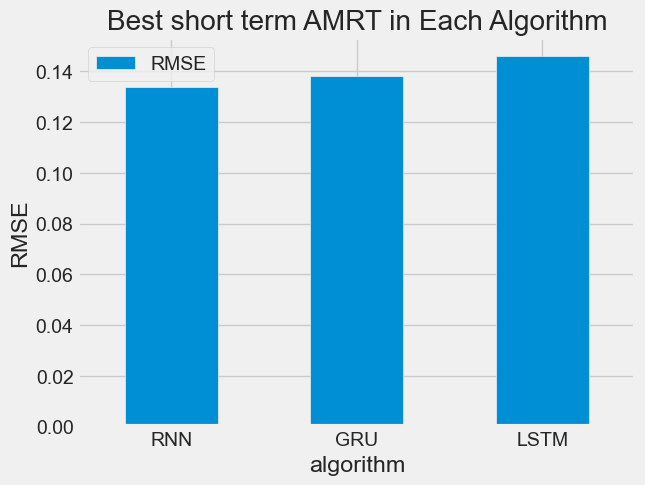

In [1108]:
data_tuning_short_AMRT = pd.concat([minimum_config_RNN_AMRT, minimum_config_GRU_AMRT, minimum_config_LSTM_AMRT]).rename(columns={"rmse_norm" : "RMSE" })
bar_AMRT_tuning_short = data_tuning_short_AMRT.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best short term AMRT in Each Algorithm")
data_tuning_short_AMRT

176 63
2/2 [==============================] - 1s 16ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

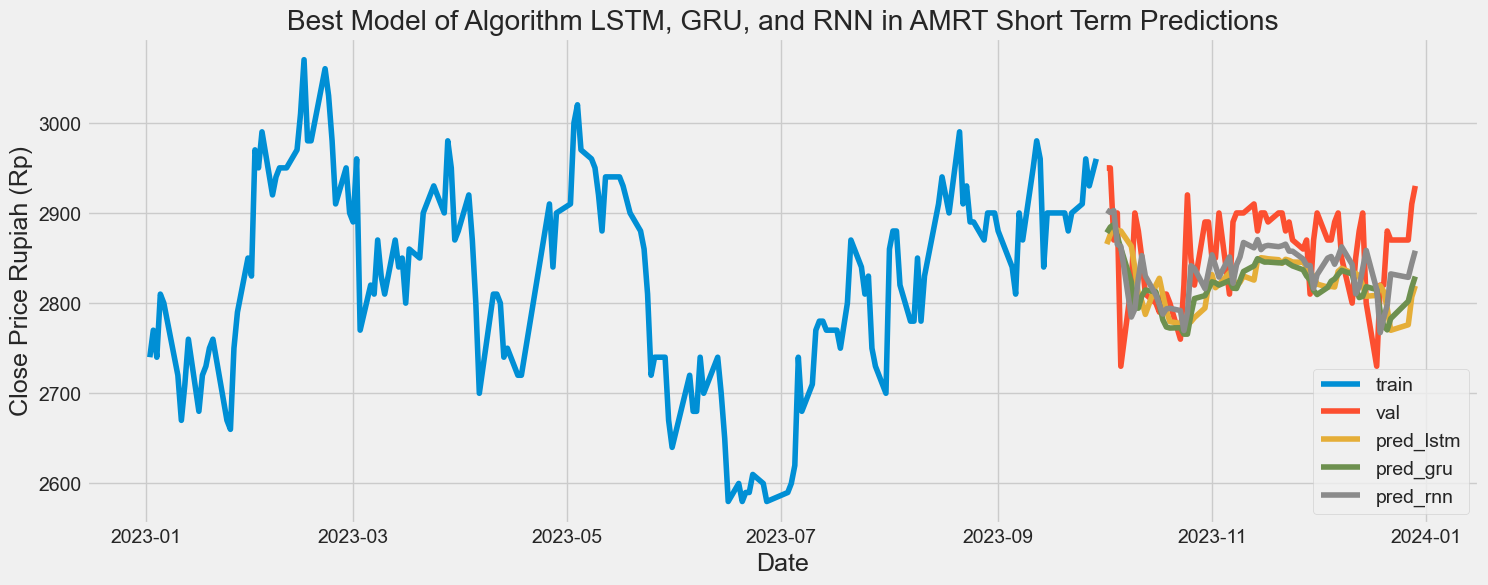

In [1293]:
rnn_best = ['adam', 64, 100, 50] 
gru_best =['rmsprop', 32, 50, 50]
lstm_best = ['rmsprop', 32, 50, 100]
show_all_algorithm(AMRT, "short", "2023-01-01", "2023-09-30", "2023-12-31", 5, "AMRT", lstm_best, gru_best, rnn_best)

In [1109]:
#Best Model for AMRT short
minimum_AMRT_short = data_tuning_short_AMRT["RMSE"].min()
minimum_config_AMRT_short = data_tuning_short_AMRT[data_tuning_short_AMRT["RMSE"] == minimum_AMRT_short]
minimum_config_AMRT_short

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
293  AMRT  short       RNN  53.530476  0.133826    100    50      adam   

     batch_size  
293          64

176 63
2/2 [==============================] - 0s 0s/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


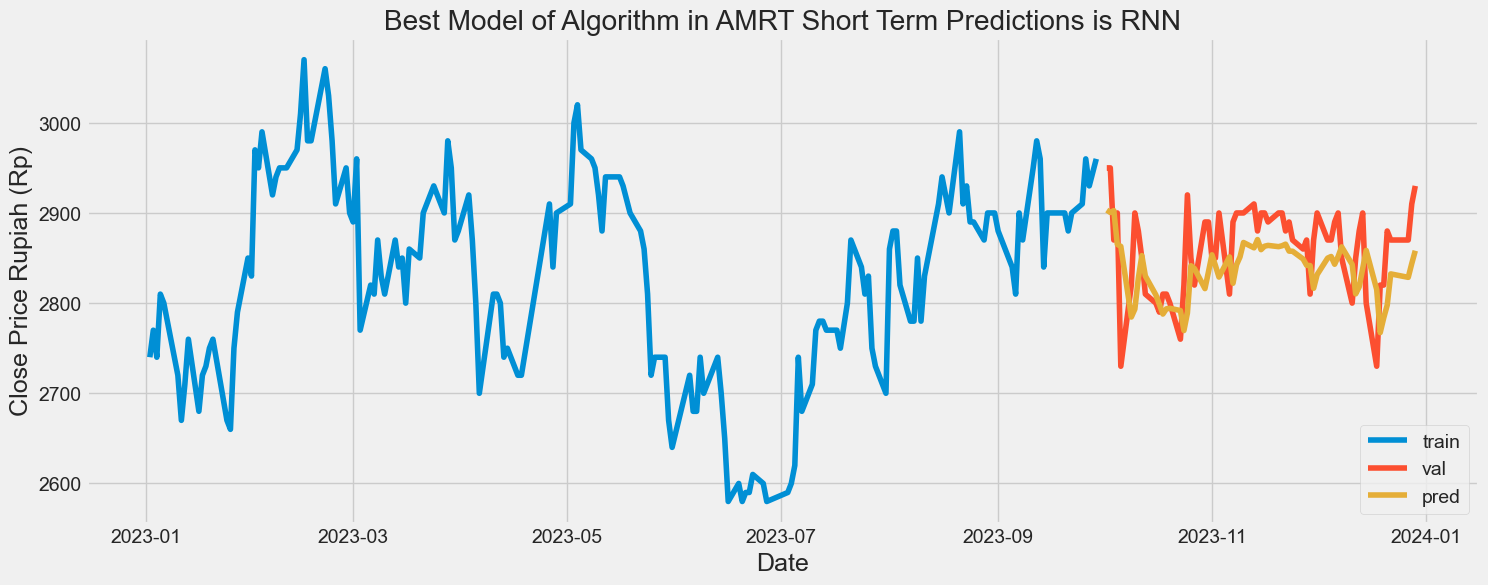

In [1267]:
show_each_algorithm(AMRT, "short","2023-01-01", "2023-09-30", "2023-12-31", 5, "AMRT", "rnn", "adam", 64, 100, 50)

### ADRO

In [1110]:
data_ADRO_short = model_short[model_short["stock"] == "ADRO"]
data_ADRO_short.head()

stock   term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
6   ADRO  short      LSTM   86.596708   0.185508     50    50   rmsprop   
7   ADRO  short       GRU   76.219152   0.177254     50    50   rmsprop   
8   ADRO  short       RNN  129.599165   0.226767     50    50   rmsprop   
24  ADRO  short      LSTM  100.849149   0.197366     50    50      adam   
25  ADRO  short       GRU   72.202377   0.167913     50    50      adam   

    batch_size  
6           32  
7           32  
8           32  
24          32  
25          32

#### LSTM

In [1111]:
data_ADRO_LSTM_short = data_ADRO_short[data_ADRO_short["algorithm"] == "LSTM"]
minimum_LSTM_ADRO = data_ADRO_LSTM_short["rmse_norm"].min()
minimum_config_LSTM_ADRO = data_ADRO_LSTM_short[data_ADRO_LSTM_short["rmse_norm"] == minimum_LSTM_ADRO]
minimum_config_LSTM_ADRO

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
168  ADRO  short      LSTM  86.966917   0.184844     50   100   rmsprop   

     batch_size  
168          64

#### GRU

In [1112]:
data_ADRO_GRU_short = data_ADRO_short[data_ADRO_short["algorithm"] == "GRU"]
minimum_GRU_ADRO = data_ADRO_GRU_short["rmse_norm"].min()
minimum_config_GRU_ADRO = data_ADRO_GRU_short[data_ADRO_GRU_short["rmse_norm"] == minimum_GRU_ADRO]
minimum_config_GRU_ADRO

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
349  ADRO  short       GRU  70.926662   0.147607    100   100      adam   

     batch_size  
349          32

#### RNN

In [1113]:
data_ADRO_RNN_short = data_ADRO_short[data_ADRO_short["algorithm"] == "RNN"]
minimum_RNN_ADRO = data_ADRO_RNN_short["rmse_norm"].min()
minimum_config_RNN_ADRO = data_ADRO_RNN_short[data_ADRO_RNN_short["rmse_norm"] == minimum_RNN_ADRO]
minimum_config_RNN_ADRO

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
224  ADRO  short       RNN  52.127727   0.121227    100    50   rmsprop   

     batch_size  
224          32

#### Best Model

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
224  ADRO  short       RNN  52.127727  0.121227    100    50   rmsprop   
349  ADRO  short       GRU  70.926662  0.147607    100   100      adam   
168  ADRO  short      LSTM  86.966917  0.184844     50   100   rmsprop   

     batch_size  
224          32  
349          32  
168          64

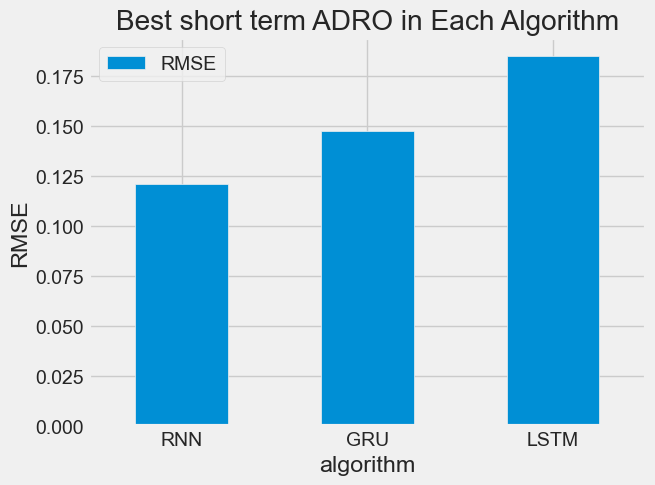

In [1114]:
data_tuning_short_ADRO = pd.concat([minimum_config_RNN_ADRO, minimum_config_GRU_ADRO, minimum_config_LSTM_ADRO]).rename(columns={"rmse_norm" : "RMSE" })
bar_ADRO_tuning_short = data_tuning_short_ADRO.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best short term ADRO in Each Algorithm")
data_tuning_short_ADRO

176 63
2/2 [==============================] - 1s 16ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

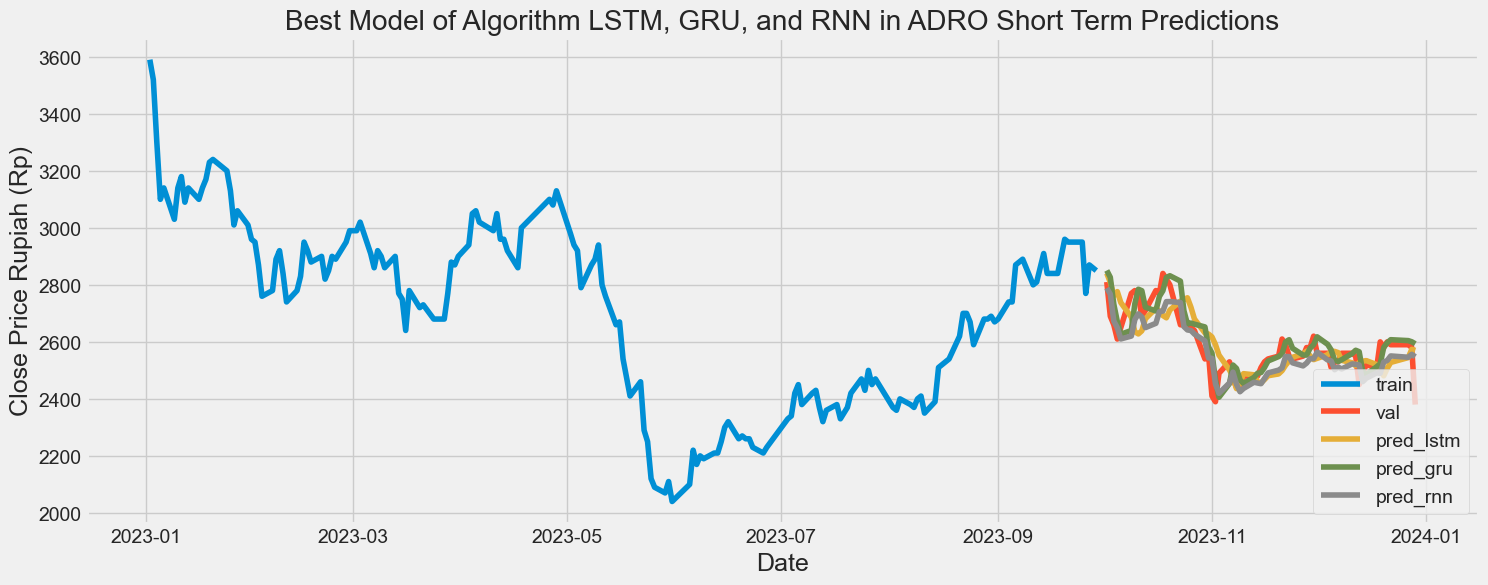

In [1292]:
rnn_best = ['rmsprop', 32, 100, 50] 
gru_best =['adam', 32, 100, 100]
lstm_best = ['rmsprop', 64, 50, 100]
show_all_algorithm(ADRO, "short", "2023-01-01", "2023-09-30", "2023-12-31", 5, "ADRO", lstm_best, gru_best, rnn_best)

In [1115]:
#Best Model for ADRO short
minimum_ADRO_short = data_tuning_short_ADRO["RMSE"].min()
minimum_config_ADRO_short = data_tuning_short_ADRO[data_tuning_short_ADRO["RMSE"] == minimum_ADRO_short]
minimum_config_ADRO_short

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
224  ADRO  short       RNN  52.127727  0.121227    100    50   rmsprop   

     batch_size  
224          32

176 63
2/2 [==============================] - 1s 0s/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


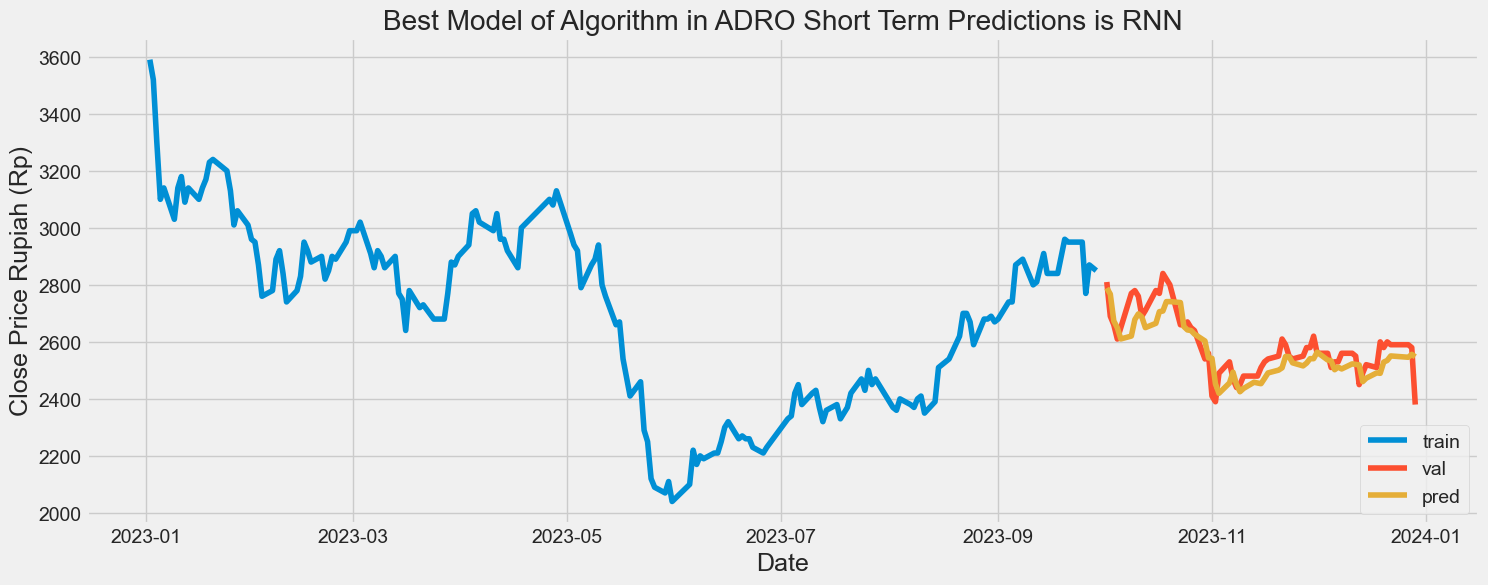

In [1268]:
show_each_algorithm(ADRO, "short","2023-01-01", "2023-09-30", "2023-12-31", 5, "ADRO", "rnn", "rmsprop", 32, 100, 50)

### MAPI

In [1116]:
data_MAPI_short = model_short[model_short["stock"] == "MAPI"]
data_MAPI_short.head()

stock   term algorithm        rmse  rmse_norm  epoch  unit optimizer  \
9   MAPI  short      LSTM   80.179588   0.190904     50    50   rmsprop   
10  MAPI  short       GRU  122.991961   0.254263     50    50   rmsprop   
11  MAPI  short       RNN  190.287320   0.336844     50    50   rmsprop   
27  MAPI  short      LSTM   85.593025   0.203793     50    50      adam   
28  MAPI  short       GRU   82.254511   0.195459     50    50      adam   

    batch_size  
9           32  
10          32  
11          32  
27          32  
28          32

#### LSTM

In [1117]:
data_MAPI_LSTM_short = data_MAPI_short[data_MAPI_short["algorithm"] == "LSTM"]
minimum_LSTM_MAPI = data_MAPI_LSTM_short["rmse_norm"].min()
minimum_config_LSTM_MAPI = data_MAPI_LSTM_short[data_MAPI_LSTM_short["rmse_norm"] == minimum_LSTM_MAPI]
minimum_config_LSTM_MAPI

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
333  MAPI  short      LSTM  75.204565   0.179058    100   100   rmsprop   

     batch_size  
333          32

#### GRU

In [1118]:
data_MAPI_GRU_short = data_MAPI_short[data_MAPI_short["algorithm"] == "GRU"]
minimum_GRU_MAPI = data_MAPI_GRU_short["rmse_norm"].min()
minimum_config_GRU_MAPI = data_MAPI_GRU_short[data_MAPI_GRU_short["rmse_norm"] == minimum_GRU_MAPI]
minimum_config_GRU_MAPI

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
352  MAPI  short       GRU  53.866994   0.128255    100   100      adam   

     batch_size  
352          32

#### RNN

In [1119]:
data_MAPI_RNN_short = data_MAPI_short[data_MAPI_short["algorithm"] == "RNN"]
minimum_RNN_MAPI = data_MAPI_RNN_short["rmse_norm"].min()
minimum_config_RNN_MAPI = data_MAPI_RNN_short[data_MAPI_RNN_short["rmse_norm"] == minimum_RNN_MAPI]
minimum_config_RNN_MAPI

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
245  MAPI  short       RNN  66.600951   0.158574    100    50      adam   

     batch_size  
245          32

#### Best Model

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
245  MAPI  short       RNN  66.600951  0.158574    100    50      adam   
352  MAPI  short       GRU  53.866994  0.128255    100   100      adam   
333  MAPI  short      LSTM  75.204565  0.179058    100   100   rmsprop   

     batch_size  
245          32  
352          32  
333          32

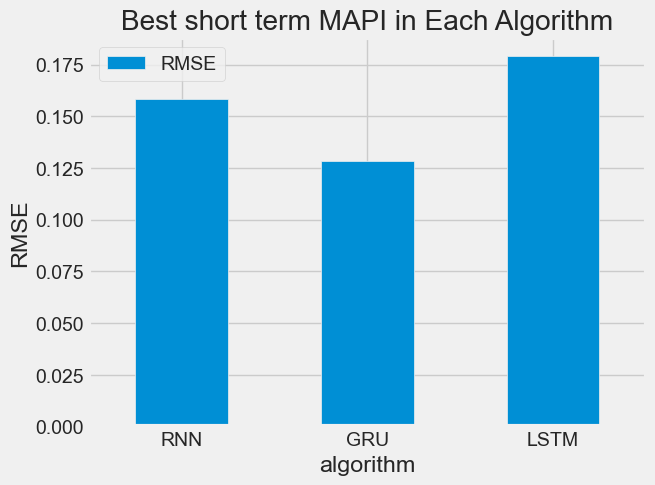

In [1120]:
data_tuning_short_MAPI = pd.concat([minimum_config_RNN_MAPI, minimum_config_GRU_MAPI, minimum_config_LSTM_MAPI]).rename(columns={"rmse_norm" : "RMSE" })
bar_MAPI_tuning_short = data_tuning_short_MAPI.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best short term MAPI in Each Algorithm")
data_tuning_short_MAPI

176 63
2/2 [==============================] - 0s 0s/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

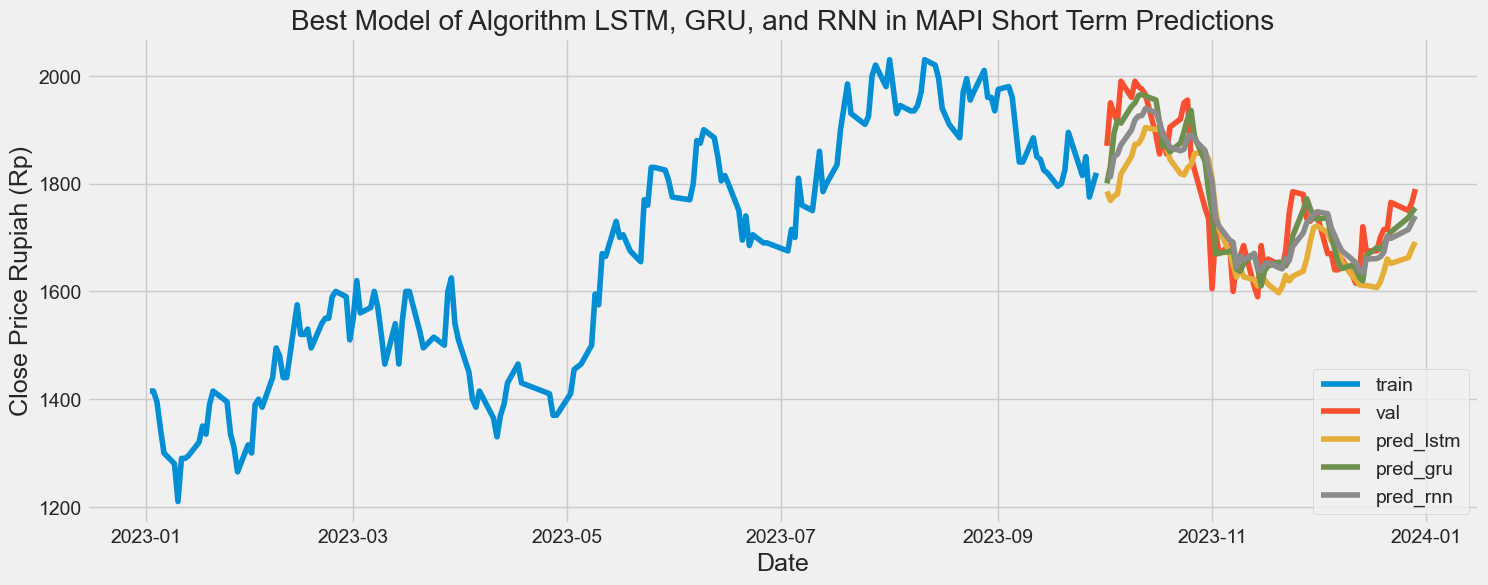

In [1291]:
rnn_best = ['adam', 32, 100, 50] 
gru_best =['adam', 32, 100, 100]
lstm_best = ['rmsprop', 32, 100, 100]
show_all_algorithm(MAPI, "short", "2023-01-01", "2023-09-30", "2023-12-31", 5, "MAPI", lstm_best, gru_best, rnn_best)

In [1121]:
#Best Model for MAPI short
minimum_MAPI_short = data_tuning_short_MAPI["RMSE"].min()
minimum_config_MAPI_short = data_tuning_short_MAPI[data_tuning_short_MAPI["RMSE"] == minimum_MAPI_short]
minimum_config_MAPI_short

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
352  MAPI  short       GRU  53.866994  0.128255    100   100      adam   

     batch_size  
352          32

176 63
2/2 [==============================] - 1s 16ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


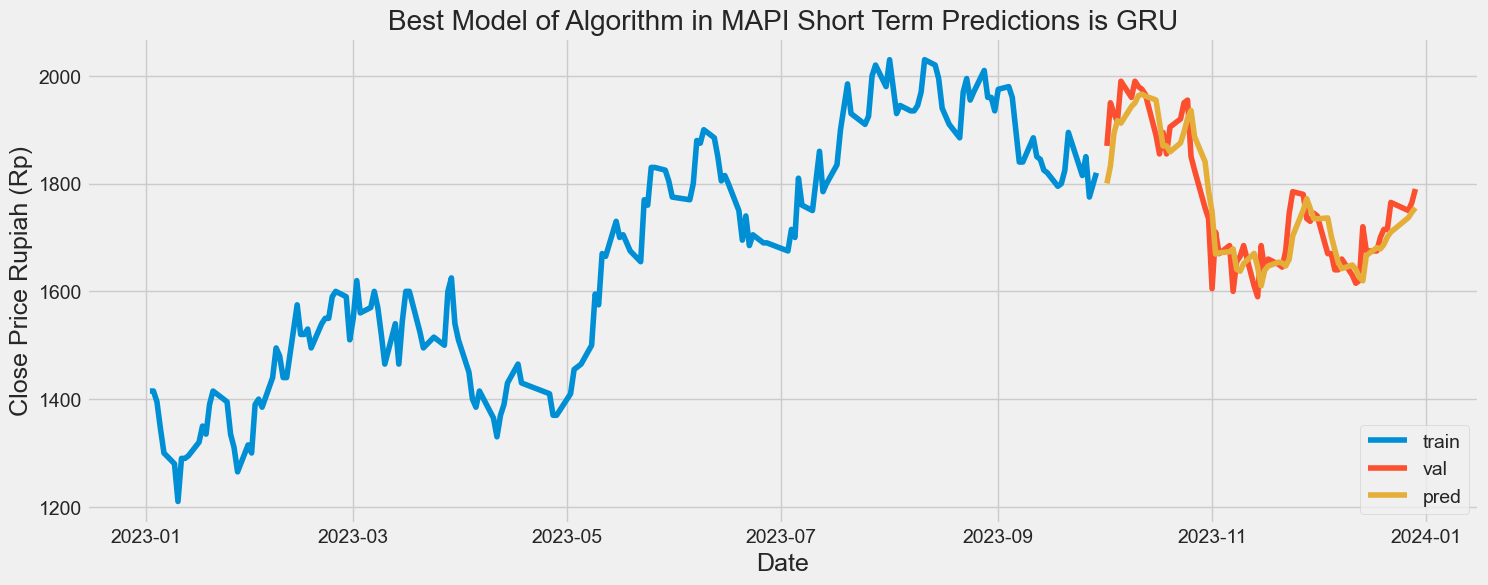

In [1269]:
show_each_algorithm(MAPI, "short","2023-01-01", "2023-09-30", "2023-12-31", 5, "MAPI", "gru", "adam", 32, 100, 100)

### KLBF

In [1122]:
data_KLBF_short = model_short[model_short["stock"] == "KLBF"]
data_KLBF_short.head()

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
12  KLBF  short      LSTM  57.808688   0.202838     50    50   rmsprop   
13  KLBF  short       GRU  58.695687   0.205950     50    50   rmsprop   
14  KLBF  short       RNN  45.857855   0.160905     50    50   rmsprop   
30  KLBF  short      LSTM  58.659220   0.205822     50    50      adam   
31  KLBF  short       GRU  51.675253   0.181317     50    50      adam   

    batch_size  
12          32  
13          32  
14          32  
30          32  
31          32

#### LSTM

In [1123]:
data_KLBF_LSTM_short = data_KLBF_short[data_KLBF_short["algorithm"] == "LSTM"]
minimum_LSTM_KLBF = data_KLBF_LSTM_short["rmse_norm"].min()
minimum_config_LSTM_KLBF = data_KLBF_LSTM_short[data_KLBF_LSTM_short["rmse_norm"] == minimum_LSTM_KLBF]
minimum_config_LSTM_KLBF

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
336  KLBF  short      LSTM  48.880918   0.171512    100   100   rmsprop   

     batch_size  
336          32

#### GRU

In [1124]:
data_KLBF_GRU_short = data_KLBF_short[data_KLBF_short["algorithm"] == "GRU"]
minimum_GRU_KLBF = data_KLBF_GRU_short["rmse_norm"].min()
minimum_config_GRU_KLBF = data_KLBF_GRU_short[data_KLBF_GRU_short["rmse_norm"] == minimum_GRU_KLBF]
minimum_config_GRU_KLBF

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
355  KLBF  short       GRU  38.398818   0.134733    100   100      adam   

     batch_size  
355          32

#### RNN


In [1125]:
data_KLBF_RNN_short = data_KLBF_short[data_KLBF_short["algorithm"] == "RNN"]
minimum_RNN_KLBF = data_KLBF_RNN_short["rmse_norm"].min()
minimum_config_RNN_KLBF = data_KLBF_RNN_short[data_KLBF_RNN_short["rmse_norm"] == minimum_RNN_KLBF]
minimum_config_RNN_KLBF

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
338  KLBF  short       RNN  35.548137    0.12473    100   100   rmsprop   

     batch_size  
338          32

#### Best Model

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
338  KLBF  short       RNN  35.548137  0.124730    100   100   rmsprop   
355  KLBF  short       GRU  38.398818  0.134733    100   100      adam   
336  KLBF  short      LSTM  48.880918  0.171512    100   100   rmsprop   

     batch_size  
338          32  
355          32  
336          32

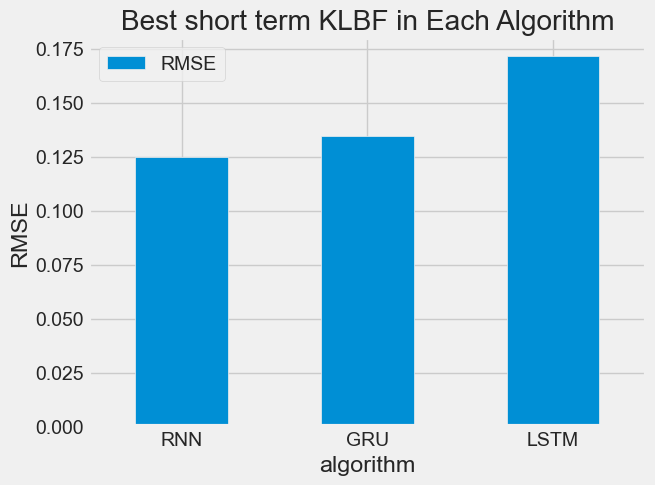

In [1126]:
data_tuning_short_KLBF = pd.concat([minimum_config_RNN_KLBF, minimum_config_GRU_KLBF, minimum_config_LSTM_KLBF]).rename(columns={"rmse_norm" : "RMSE" })
bar_KLBF_tuning_short = data_tuning_short_KLBF.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best short term KLBF in Each Algorithm")
data_tuning_short_KLBF

176 63
2/2 [==============================] - 1s 0s/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

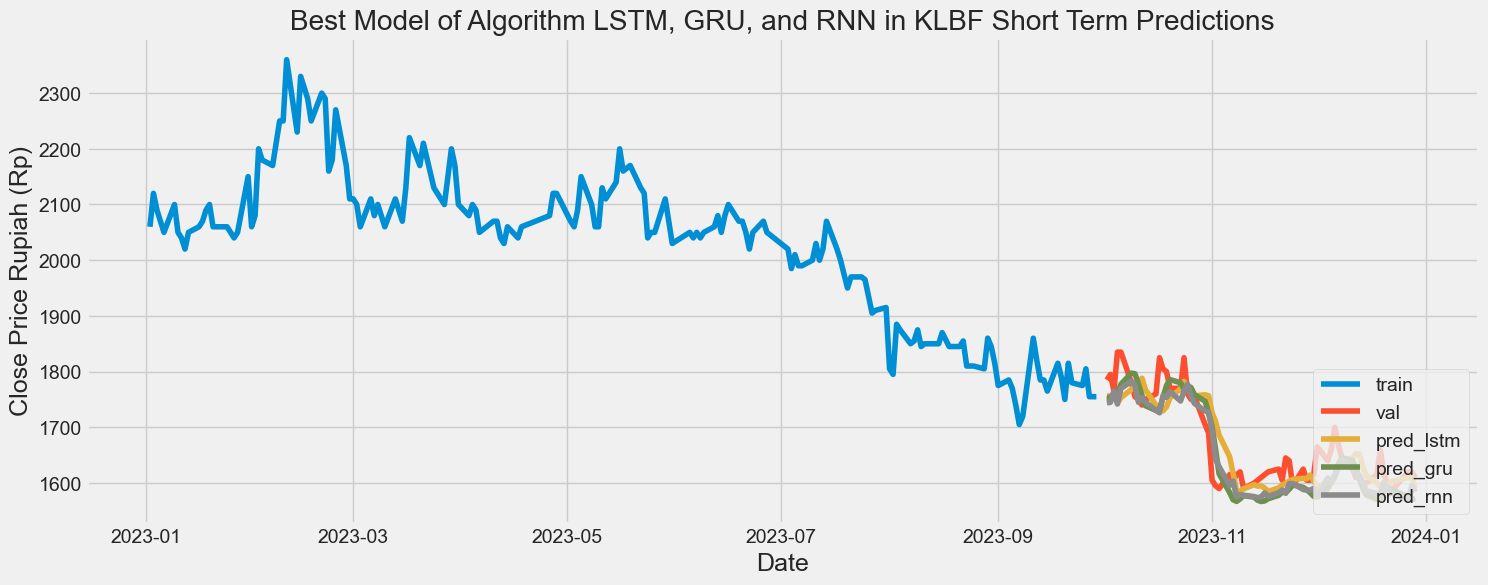

In [1290]:
rnn_best = ['rmsprop', 32, 100, 100] 
gru_best =['adam', 32, 100, 100]
lstm_best = ['rmsprop', 32, 100, 100]
show_all_algorithm(KLBF, "short", "2023-01-01", "2023-09-30", "2023-12-31", 5, "KLBF", lstm_best, gru_best, rnn_best)

In [1127]:
#Best Model for KLBF short
minimum_KLBF_short = data_tuning_short_KLBF["RMSE"].min()
minimum_config_KLBF_short = data_tuning_short_KLBF[data_tuning_short_KLBF["RMSE"] == minimum_KLBF_short]
minimum_config_KLBF_short

stock   term algorithm       rmse     RMSE  epoch  unit optimizer  \
338  KLBF  short       RNN  35.548137  0.12473    100   100   rmsprop   

     batch_size  
338          32

176 63
2/2 [==============================] - 1s 18ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


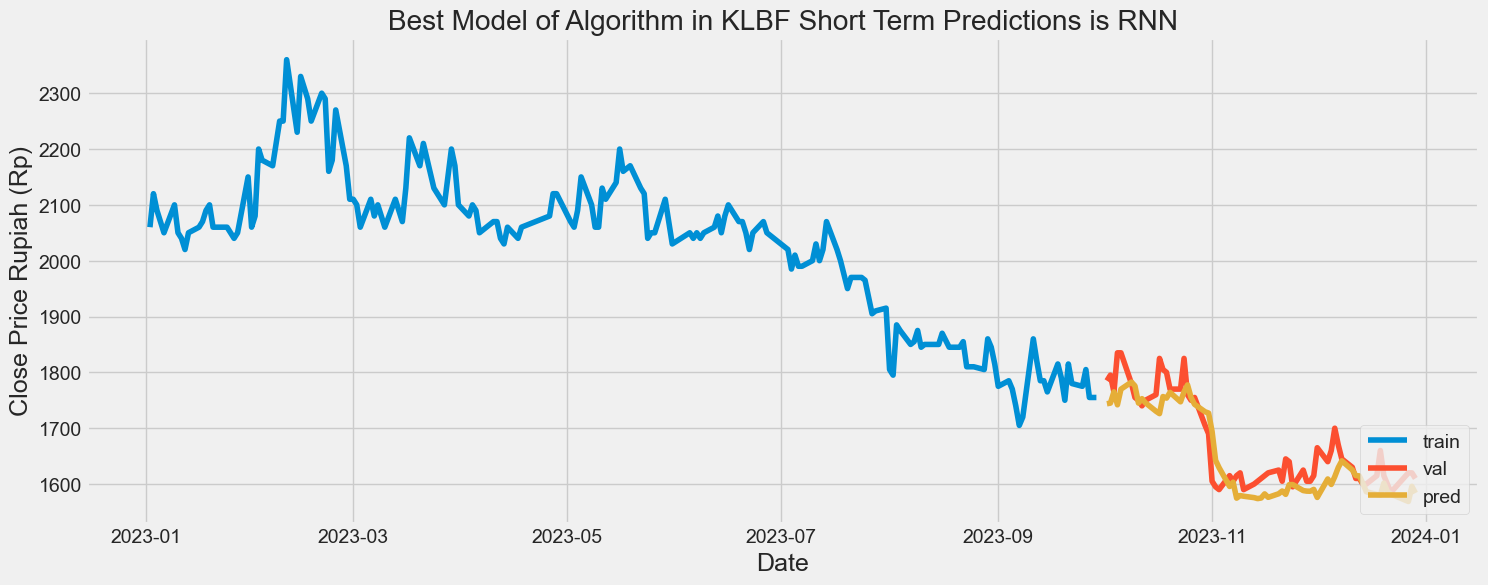

In [1270]:
show_each_algorithm(KLBF, "short","2023-01-01", "2023-09-30", "2023-12-31", 5, "KLBF", "rnn", "rmsprop", 32, 100, 100)

### TLKM

In [1128]:
data_TLKM_short = model_short[model_short["stock"] == "TLKM"]
data_TLKM_short.head()

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
15  TLKM  short      LSTM  85.797963   0.150523     50    50   rmsprop   
16  TLKM  short       GRU  71.596323   0.125608     50    50   rmsprop   
17  TLKM  short       RNN  58.406603   0.102468     50    50   rmsprop   
33  TLKM  short      LSTM  89.940284   0.157147     50    50      adam   
34  TLKM  short       GRU  64.230574   0.111828     50    50      adam   

    batch_size  
15          32  
16          32  
17          32  
33          32  
34          32

#### LSTM

In [1129]:
data_TLKM_LSTM_short = data_TLKM_short[data_TLKM_short["algorithm"] == "LSTM"]
minimum_LSTM_TLKM = data_TLKM_LSTM_short["rmse_norm"].min()
minimum_config_LSTM_TLKM = data_TLKM_LSTM_short[data_TLKM_LSTM_short["rmse_norm"] == minimum_LSTM_TLKM]
minimum_config_LSTM_TLKM

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
357  TLKM  short      LSTM  68.829442   0.113807    100   100      adam   

     batch_size  
357          32

#### GRU

In [1130]:
data_TLKM_GRU_short = data_TLKM_short[data_TLKM_short["algorithm"] == "GRU"]
minimum_GRU_TLKM = data_TLKM_GRU_short["rmse_norm"].min()
minimum_config_GRU_TLKM = data_TLKM_GRU_short[data_TLKM_GRU_short["rmse_norm"] == minimum_GRU_TLKM]
minimum_config_GRU_TLKM

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
358  TLKM  short       GRU  49.743359   0.086248    100   100      adam   

     batch_size  
358          32

#### RNN

In [1131]:
data_TLKM_RNN_short = data_TLKM_short[data_TLKM_short["algorithm"] == "RNN"]
minimum_RNN_TLKM = data_TLKM_RNN_short["rmse_norm"].min()
minimum_config_RNN_TLKM = data_TLKM_RNN_short[data_TLKM_RNN_short["rmse_norm"] == minimum_RNN_TLKM]
minimum_config_RNN_TLKM

stock   term algorithm       rmse  rmse_norm  epoch  unit optimizer  \
395  TLKM  short       RNN  51.141998   0.087921    100   100   rmsprop   

     batch_size  
395          64

#### Best Model

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
395  TLKM  short       RNN  51.141998  0.087921    100   100   rmsprop   
358  TLKM  short       GRU  49.743359  0.086248    100   100      adam   
357  TLKM  short      LSTM  68.829442  0.113807    100   100      adam   

     batch_size  
395          64  
358          32  
357          32

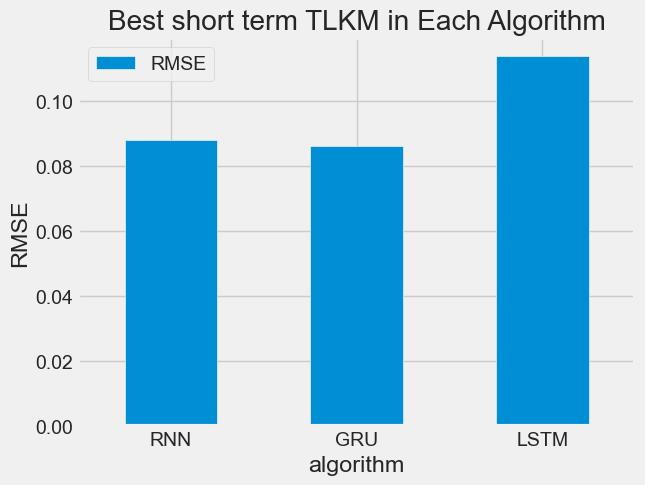

In [1132]:
data_tuning_short_TLKM = pd.concat([minimum_config_RNN_TLKM, minimum_config_GRU_TLKM, minimum_config_LSTM_TLKM]).rename(columns={"rmse_norm" : "RMSE" })
bar_TLKM_tuning_short = data_tuning_short_TLKM.plot.bar(x='algorithm', y=['RMSE'], ylabel="RMSE", rot=0, title="Best short term TLKM in Each Algorithm")
data_tuning_short_TLKM

176 63
2/2 [==============================] - 0s 0s/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_lstm'] = LSTM_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred_gru'] = GRU_predicted_stock_price
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\2896427360.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

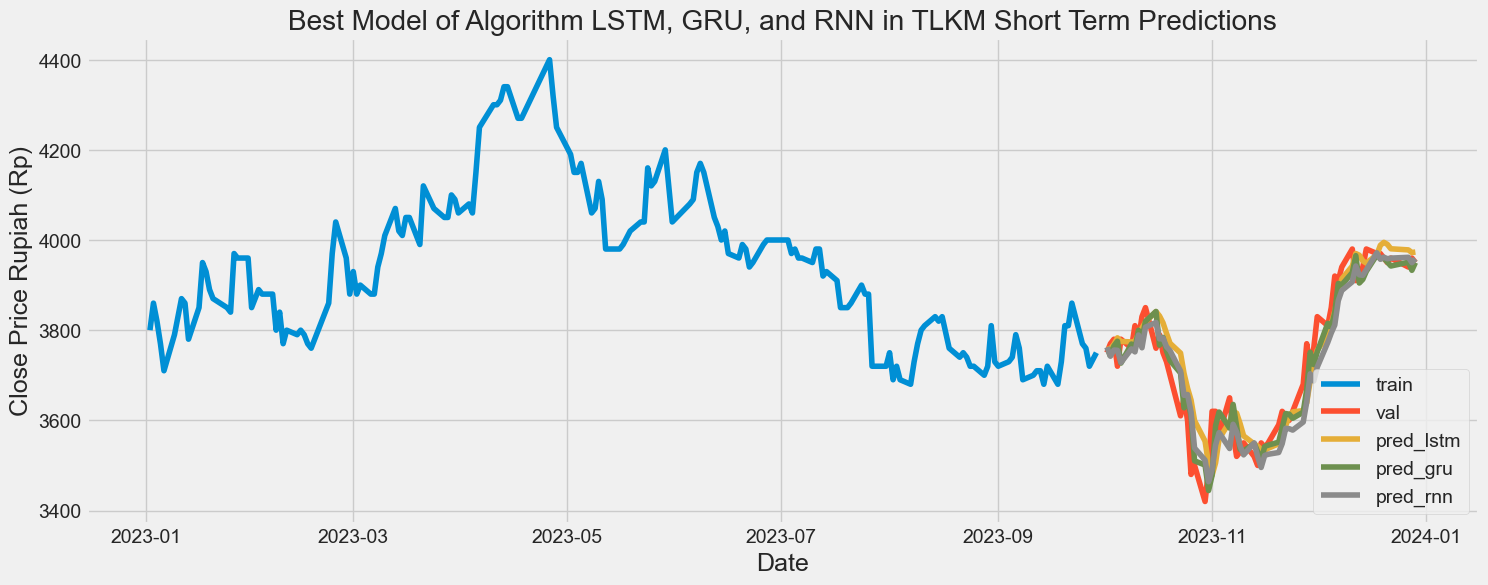

In [1289]:
rnn_best = ['rmsprop', 64, 100, 100] 
gru_best =['adam', 32, 100, 100]
lstm_best = ['adam', 32, 100, 100]
show_all_algorithm(TLKM, "short", "2023-01-01", "2023-09-30", "2023-12-31", 5, "TLKM", lstm_best, gru_best, rnn_best)

In [1133]:
#Best Model for TLKM short
minimum_TLKM_short = data_tuning_short_TLKM["RMSE"].min()
minimum_config_TLKM_short = data_tuning_short_TLKM[data_tuning_short_TLKM["RMSE"] == minimum_TLKM_short]
minimum_config_TLKM_short

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
358  TLKM  short       GRU  49.743359  0.086248    100   100      adam   

     batch_size  
358          32

176 63
2/2 [==============================] - 1s 16ms/step


C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8756\3429872426.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pred'] = predicted_stock_price


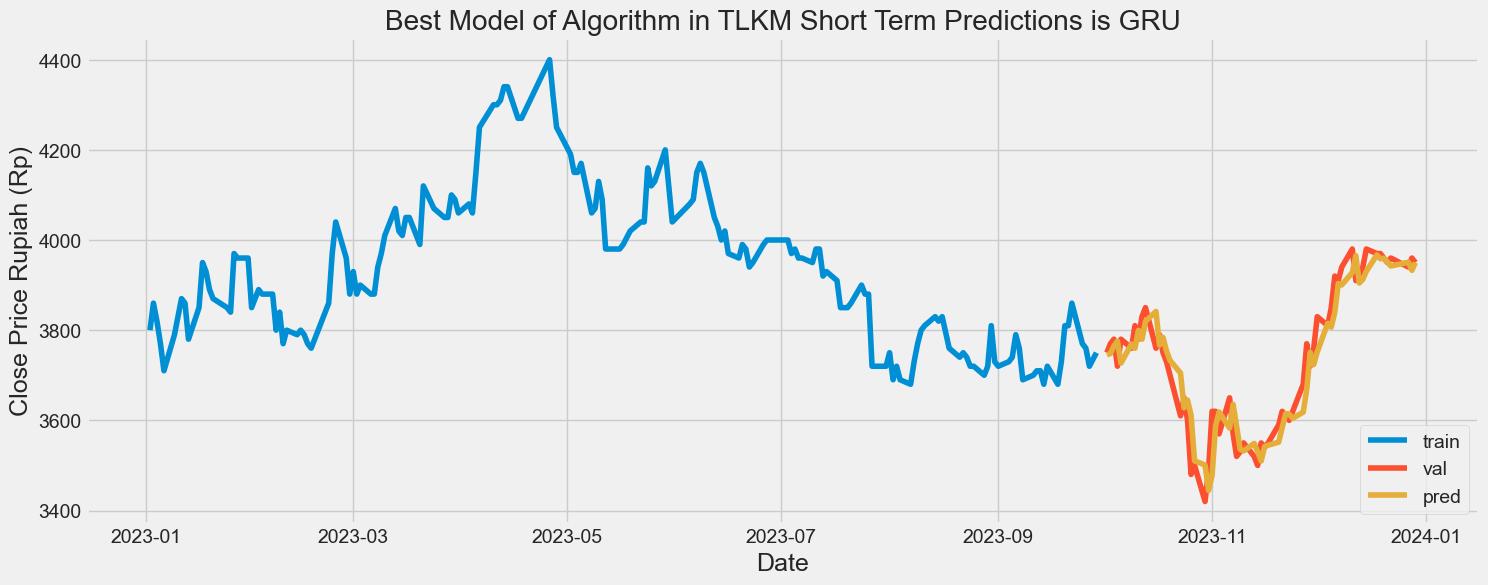

In [1271]:
show_each_algorithm(TLKM, "short","2023-01-01", "2023-09-30", "2023-12-31", 5, "TLKM", "gru", "adam", 32, 100, 100)

### Best Model for Each Stock in Short Term

stock   term algorithm       rmse      RMSE  epoch  unit optimizer  \
272  ASII  short       RNN  74.386256  0.087513    100    50   rmsprop   
293  AMRT  short       RNN  53.530476  0.133826    100    50      adam   
224  ADRO  short       RNN  52.127727  0.121227    100    50   rmsprop   
352  MAPI  short       GRU  53.866994  0.128255    100   100      adam   
338  KLBF  short       RNN  35.548137  0.124730    100   100   rmsprop   
358  TLKM  short       GRU  49.743359  0.086248    100   100      adam   

     batch_size  
272          64  
293          64  
224          32  
352          32  
338          32  
358          32

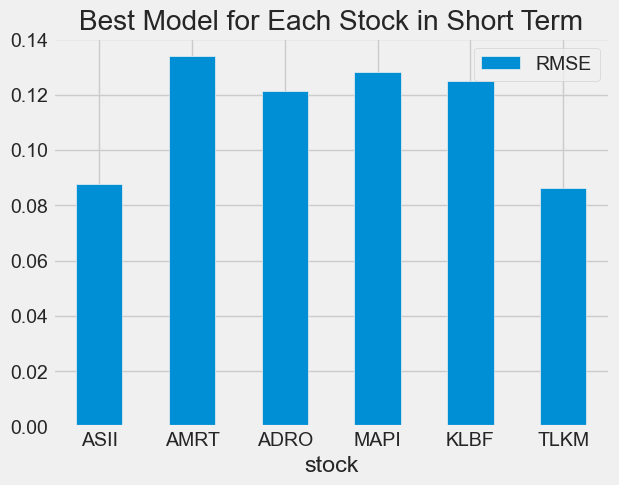

In [1134]:
best_data_short = pd.concat([minimum_config_ASII_short,
                            minimum_config_AMRT_short,
                            minimum_config_ADRO_short,
                            minimum_config_MAPI_short,
                            minimum_config_KLBF_short,
                            minimum_config_TLKM_short]
                            )
bar_tuning_short = best_data_short.plot.bar(x='stock', y=['RMSE'], rot=0, title="Best Model for Each Stock in Short Term")
best_data_short